# DQN拡張手法比較プロジェクト（SpaceInvaders環境でのAblation Study）

## プロジェクト概要

本プロジェクトでは、深層強化学習の基礎となるDQN（Deep Q-Network）アルゴリズムに対して、主要な拡張手法である**Double DQN**と**Prioritized Experience Replay**（**PER**）を実装し、それらの効果をベースラインと比較するAblation Study（除去実験）を行います。

### 実験対象アルゴリズム

1. **Vanilla DQN** (ベースライン)
   - 基本的なDQNアルゴリズム
   - 通常のExperience Replay (一様ランダムサンプリング)
   - Target Network + ε-greedy探索

2. **Double DQN**
   - Q値の過大評価問題を解決
   - 行動選択と価値評価の分離
   - TD目標の修正: $Y_t = R_{t+1} + \gamma Q_{\theta'}(S_{t+1}, \arg\max_{a'} Q_{\theta}(S_{t+1}, a'))$

3. **Double DQN + PER**
   - Double DQNにPrioritized Experience Replayを追加
   - TD誤差に基づく重要度サンプリング
   - Importance Sampling重みによるバイアス補正

### 実験環境・評価指標

- **環境**: Atari SpaceInvaders-v5
- **評価指標**: 学習曲線（エピソード報酬の推移）、収束速度、最終性能
- **学習設定**: 各モデル100万タイムステップ

## 目次

1. [環境構築とライブラリインポート](#1-環境構築とライブラリインポート)
2. [Atari環境のWrapper設定](#2-Atari環境のWrapper設定)
3. [ベースラインDQNネットワーク実装](#3-ベースラインDQNネットワーク実装)
4. [通常のReplay Buffer実装](#4-通常のReplay-Buffer実装)
5. [Sum Tree実装](#5-Sum-Tree実装)
6. [Prioritized Replay Buffer実装](#6-Prioritized-Replay-Buffer実装)
7. [Vanilla DQNエージェント実装](#7-Vanilla-DQNエージェント実装)
8. [Double DQNエージェント実装](#8-Double-DQNエージェント実装)
9. [PER付きDQNエージェント実装](#9-PER付きDQNエージェント実装)
10. [学習ループとログ機能](#10-学習ループとログ機能)
11. [実験実行と比較](#11-実験実行と比較)
12. [結果可視化と分析](#12-結果可視化と分析)

## 1. 環境構築とライブラリインポート

まず必要なライブラリを読み込み、GPU環境の確認を行います。

### 依存関係のインストール（GPU環境での実行時）
GPU環境（Google Colab Pro等）で実行する際は以下のコマンドでライブラリをインストールします。

```bash
!pip install --upgrade numpy torch torchvision
!pip install gymnasium[atari]
!pip install "autorom[accept-rom-license]"
!pip install matplotlib seaborn tensorboard tqdm
```

In [1]:
!pip install --upgrade numpy torch torchvision
!pip install gymnasium[atari]
!pip install "autorom[accept-rom-license]"
!pip install matplotlib seaborn tensorboard tqdm

In [2]:
# 必要なライブラリのインポート
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from collections import deque
import time
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym
import ale_py
from IPython.display import HTML

# Numpy bool8 deprecation対応
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool

# プロット設定
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [3]:
# GPU環境の確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")
else:
    print("CPU環境で実行されます（学習は推奨されません）")

!nvidia-smi

使用デバイス: cuda
GPU: Tesla T4
CUDA Version: 12.6
PyTorch Version: 2.8.0+cu126
Sun Sep 28 15:28:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                      

## 2. Atari環境のWrapper設定

強化学習を行う上で扱いやすくするために、元の環境をそのまま用いるのではなく、いくつかのWrapperを適用します。これらのWrapperは元のbaselines実装を参考にしています。

In [4]:
# Atari環境用Wrapperクラス群
# 参考: https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class NoopResetEnv(gym.Wrapper):
    """初期状態を多様化するため、ランダムに選んだ回数最初に「何もしない」行動をする"""
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, reward, done, truncated, info = self.env.step(self.noop_action)
            if done or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)


class MaxAndSkipEnv(gym.Wrapper):
    """選んだ同じ行動を何度か繰り返す。同時にフレームの偶奇対応のため直近２フレームでMaxを取る"""
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = truncated = False
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done or truncated:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class EpisodicLifeEnv(gym.Wrapper):
    """残機が複数あるゲームでも１機失うたびに終了とする (done=True)。ただし、状態はリセットしない"""
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.was_real_done = done or truncated
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            obs, _, _, _, info = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info


class FireResetEnv(gym.Wrapper):
    """最初にエージェントが"FIRE"しないとゲームが開始しないため、自動で"FIRE"してゲームを開始"""
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs, _, done, truncated, _ = self.env.step(1)
        if done or truncated:
            obs, info = self.env.reset(**kwargs)
        obs, _, done, truncated, _ = self.env.step(2)
        if done or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)


class WarpFrame(gym.ObservationWrapper):
    """画像サイズを84x84に縮小し、グレイスケール化する"""
    def __init__(self, env, width=84, height=84, grayscale=True):
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        self.observation_space = new_space

    def observation(self, obs):
        if self._grayscale:
            obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs = cv2.resize(obs, (self._width, self._height), interpolation=cv2.INTER_AREA)
        if self._grayscale:
            obs = np.expand_dims(obs, -1)
        return obs


class ClipRewardEnv(gym.RewardWrapper):
    """報酬を {-1, 0, 1} にクリップする"""
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        return np.sign(reward)


class TorchFrame(gym.ObservationWrapper):
    """PyTorchで扱いやすいようにChannel-Firstに変更し、Torch.Tensorに変換する"""
    def __init__(self, env):
        super().__init__(env)
        height, width, channels = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(channels, height, width),
            dtype=np.uint8,
        )

    def observation(self, obs):
        return torch.as_tensor(obs.transpose([2, 0, 1]))

In [5]:
# SpaceInvaders環境の作成関数
def make_env(noop_max=30, skip=4, width=84, height=84, grayscale=True):
    """
    SpaceInvaders-v5環境にWrapperを適用して学習用環境を作成
    """
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')
    env = NoopResetEnv(env, noop_max=noop_max)
    env = MaxAndSkipEnv(env, skip=skip)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    env = WarpFrame(env, width=width, height=height, grayscale=grayscale)
    env = ClipRewardEnv(env)
    env = TorchFrame(env)
    return env

env = make_env()

# テスト用に環境を作成
env = make_env()
print(f"環境: {env.spec.id}")
print(f"行動空間: {env.action_space}")
print(f"観測空間: {env.observation_space}")
print(f"行動の意味: {env.unwrapped.get_action_meanings()}")

環境: ALE/SpaceInvaders-v5
行動空間: Discrete(6)
観測空間: Box(0, 255, (1, 84, 84), uint8)
行動の意味: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [6]:
# 環境の動作確認（ランダム行動でのプレイ）
def display_video(frames, figsize=(8, 8)):
    """フレームリストから動画を表示する関数"""
    plt.figure(figsize=figsize, dpi=50)
    patch = plt.imshow(frames[0], cmap='gray')
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()
    return anim

# ランダム行動でのテストプレイ
obs, info = env.reset()
frames = []
total_reward = 0
done = truncated = False
step_count = 0

print("ランダム行動でSpaceInvadersをプレイ...")
while not (done or truncated) and step_count < 200:  # 最大200ステップ
    frames.append(obs[0].numpy())  # グレースケール画像を取得
    action = env.action_space.sample()  # ランダム行動
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1

print(f'総報酬: {total_reward}, ステップ数: {step_count}')
if len(frames) > 10:  # フレーム数が十分ある場合のみ表示
    display_video(frames[:50])  # 最初の50フレームを表示

ランダム行動でSpaceInvadersをプレイ...
総報酬: 1.0, ステップ数: 26


## 3. ベースラインDQNネットワーク実装

CNNベースのDQNネットワークを実装します。Atari環境の84x84グレースケール画像を入力とし、各行動のQ値を出力します。

In [7]:
class DQNNetwork(nn.Module):
    """
    Vanilla DQN用のCNNネットワーク
    """
    def __init__(self, input_shape, n_actions, device='cpu'):
        super(DQNNetwork, self).__init__()
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.device = device # deviceを保持

        # CNN層
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),  # 1x84x84 -> 32x20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),              # 32x20x20 -> 64x9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),              # 64x9x9 -> 64x7x7
            nn.ReLU()
        )

        # 全結合層のサイズを動的に計算
        conv_out_size = self._get_conv_out_size(input_shape)

        # 全結合層
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out_size(self, shape):
        """CNN層の出力サイズを計算"""
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_layers(dummy_input)
        return dummy_output.numel()

    def forward(self, x):
        batch_size = x.size(0)
        conv_out = self.conv_layers(x)
        conv_out = conv_out.view(batch_size, -1)  # Flatten
        q_values = self.fc_layers(conv_out)
        return q_values

    def act(self, state, epsilon):
        """ε-greedy行動選択"""
        if random.random() < epsilon:
            return random.randrange(self.n_actions)
        else:
            with torch.no_grad():
                state = state.to(self.device)
                state = state.unsqueeze(0) if state.dim() == 3 else state
                q_values = self.forward(state.float())
                return q_values.max(1)[1].item()


# ネットワークのテスト
test_net = DQNNetwork(env.observation_space.shape, env.action_space.n)
test_input = torch.randn(1, *env.observation_space.shape)
test_output = test_net(test_input)

print(f"入力サイズ: {test_input.shape}")
print(f"出力サイズ: {test_output.shape}")
print(f"ネットワーク構造:")
print(test_net)

入力サイズ: torch.Size([1, 1, 84, 84])
出力サイズ: torch.Size([1, 6])
ネットワーク構造:
DQNNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


## 4. 通常のReplay Buffer実装

Vanilla DQN用の基本的なReplay Bufferを実装します。一様ランダムサンプリングを行います。

In [8]:
class ReplayBuffer:
    """
    Vanilla DQN用の通常のReplay Buffer
    一様ランダムサンプリングを行う
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """経験をバッファに保存"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """ランダムサンプリング"""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (torch.stack(state),
                torch.tensor(action, dtype=torch.long),
                torch.tensor(reward, dtype=torch.float32),
                torch.stack(next_state),
                torch.tensor(done, dtype=torch.uint8))

    def __len__(self):
        return len(self.buffer)


# テスト用のダミーデータでReplayBufferをテスト
test_buffer = ReplayBuffer(1000)

# ダミーデータを追加
for i in range(10):
    dummy_state = torch.randn(1, 84, 84)
    dummy_action = random.randint(0, 5)
    dummy_reward = random.random()
    dummy_next_state = torch.randn(1, 84, 84)
    dummy_done = random.choice([True, False])

    test_buffer.push(dummy_state, dummy_action, dummy_reward, dummy_next_state, dummy_done)

print(f"バッファサイズ: {len(test_buffer)}")

# サンプリングテスト
if len(test_buffer) >= 5:
    batch = test_buffer.sample(5)
    states, actions, rewards, next_states, dones = batch
    print(f"サンプリング結果:")
    print(f"  States shape: {states.shape}")
    print(f"  Actions shape: {actions.shape}")
    print(f"  Rewards shape: {rewards.shape}")
    print(f"  Next states shape: {next_states.shape}")
    print(f"  Dones shape: {dones.shape}")

バッファサイズ: 10
サンプリング結果:
  States shape: torch.Size([5, 1, 84, 84])
  Actions shape: torch.Size([5])
  Rewards shape: torch.Size([5])
  Next states shape: torch.Size([5, 1, 84, 84])
  Dones shape: torch.Size([5])


## 5. Sum Tree実装

Prioritized Experience Replay（PER）で使用する効率的なデータ構造であるSum Treeを実装します。

In [9]:
class SumTree:
    """
    Prioritized Experience Replay用のSum Tree実装
    効率的な重要度サンプリングを可能にする
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # 二分木を配列で表現
        self.data = np.zeros(capacity, dtype=object)  # 実際のデータ
        self.write = 0  # データ書き込み位置
        self.n_entries = 0

    def _propagate(self, idx, change):
        """値の変更を木の上位ノードに伝播"""
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """指定された値sに対応するleaf nodeを検索"""
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """全ての優先度の合計を返す"""
        return self.tree[0]

    def add(self, priority, data):
        """データと優先度を追加"""
        idx = self.write + self.capacity - 1  # leaf nodeのインデックス

        self.data[self.write] = data
        self.update(idx, priority)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        """優先度を更新"""
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        """指定された値sに対応するデータを取得"""
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]


# Sum Treeのテスト
test_tree = SumTree(10)

# テストデータを追加
priorities = [1.0, 2.0, 3.0, 4.0, 5.0]
data_items = ['a', 'b', 'c', 'd', 'e']

for priority, data in zip(priorities, data_items):
    test_tree.add(priority, data)

print(f"Total priority: {test_tree.total()}")
print(f"Entries: {test_tree.n_entries}")

# サンプリングテスト
for i in range(3):
    s = random.uniform(0, test_tree.total())
    idx, priority, data = test_tree.get(s)
    print(f"Sample {i+1}: s={s:.2f}, idx={idx}, priority={priority:.2f}, data={data}")

Total priority: 15.0
Entries: 5
Sample 1: s=11.14, idx=13, priority=5.00, data=e
Sample 2: s=13.35, idx=13, priority=5.00, data=e
Sample 3: s=4.76, idx=11, priority=3.00, data=c


## 6. Prioritized Replay Buffer実装

TD誤差に基づく重要度サンプリングとImportance Sampling重みを計算するPER用Replay Bufferを実装します。

In [10]:
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer
    TD誤差に基づく重要度サンプリングを行う
    """
    def __init__(self, capacity, alpha=0.6, eps=1e-4):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.alpha = alpha  # 優先度の強さ
        self.eps = eps      # 優先度の最小値（ゼロ除算回避）
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        """経験をバッファに保存（最大優先度で初期化）"""
        experience = (state, action, reward, next_state, done)
        self.tree.add(self.max_priority, experience)

    def sample(self, batch_size, beta=0.4):
        """
        重要度サンプリングを行い、IS重みも計算
        beta: importance sampling weightの強さ
        """
        batch = []
        indices = []
        weights = []
        priorities = []

        # セグメント方式でサンプリング
        segment = self.tree.total() / batch_size

        for i in range(batch_size):
            # セグメント内でランダムにサンプリング
            s = random.uniform(i * segment, (i + 1) * segment)
            idx, priority, experience = self.tree.get(s)

            batch.append(experience)
            indices.append(idx)
            priorities.append(priority)

        # Importance Sampling重みを計算
        # w_i = (1 / (N * P(i)))^beta / max_w
        total_priority = self.tree.total()
        min_prob = min(priorities) / total_priority
        max_weight = (self.tree.n_entries * min_prob) ** (-beta)

        for priority in priorities:
            prob = priority / total_priority
            weight = (self.tree.n_entries * prob) ** (-beta)
            weights.append(weight / max_weight)

        # バッチデータを整理
        states, actions, rewards, next_states, dones = zip(*batch)

        return (torch.stack(states),
                torch.tensor(actions, dtype=torch.long),
                torch.tensor(rewards, dtype=torch.float32),
                torch.stack(next_states),
                torch.tensor(dones, dtype=torch.uint8),
                indices,
                torch.tensor(weights, dtype=torch.float32))

    def update_priorities(self, indices, td_errors):
        """TD誤差に基づいて優先度を更新"""
        for idx, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + self.eps) ** self.alpha
            self.max_priority = max(self.max_priority, priority)
            self.tree.update(idx, priority)

    def __len__(self):
        return self.tree.n_entries


# Prioritized Replay Bufferのテスト
test_per_buffer = PrioritizedReplayBuffer(1000)

# ダミーデータを追加
for i in range(10):
    dummy_state = torch.randn(1, 84, 84)
    dummy_action = random.randint(0, 5)
    dummy_reward = random.random()
    dummy_next_state = torch.randn(1, 84, 84)
    dummy_done = random.choice([True, False])

    test_per_buffer.push(dummy_state, dummy_action, dummy_reward, dummy_next_state, dummy_done)

print(f"PER バッファサイズ: {len(test_per_buffer)}")

# サンプリングテスト
if len(test_per_buffer) >= 5:
    batch_data = test_per_buffer.sample(5, beta=0.4)
    states, actions, rewards, next_states, dones, indices, weights = batch_data
    print(f"PER サンプリング結果:")
    print(f"  States shape: {states.shape}")
    print(f"  Actions shape: {actions.shape}")
    print(f"  Weights shape: {weights.shape}")
    print(f"  IS weights: {weights}")
    print(f"  Indices: {indices}")

PER バッファサイズ: 10
PER サンプリング結果:
  States shape: torch.Size([5, 1, 84, 84])
  Actions shape: torch.Size([5])
  Weights shape: torch.Size([5])
  IS weights: tensor([1., 1., 1., 1., 1.])
  Indices: [1000, 1002, 1003, 1005, 1007]


## 7. Vanilla DQNエージェント実装

ベースラインとなるVanilla DQNエージェントクラス（通常のReplay Buffer使用）を実装します。

In [11]:
class VanillaDQNAgent:
    """
    Vanilla DQN エージェント
    通常のExperience Replayを使用
    """
    def __init__(self, state_shape, n_actions, lr=1e-4, gamma=0.99,
                 buffer_size=100000, device='cpu'):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.device = device

        # ネットワークの初期化
        self.q_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # オプティマイザ
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Replay Buffer
        self.memory = ReplayBuffer(buffer_size)

        # 損失関数
        self.criterion = nn.SmoothL1Loss()

    def act(self, state, epsilon):
        """ε-greedy行動選択"""
        return self.q_network.act(state, epsilon)

    def store_transition(self, state, action, reward, next_state, done):
        """経験をReplay Bufferに保存"""
        self.memory.push(state, action, reward, next_state, done)

    def update(self, batch_size):
        """Q-networkの更新"""
        if len(self.memory) < batch_size:
            return None

        # バッチサンプリング
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        states = states.float().to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.float().to(self.device)
        dones = dones.to(self.device)

        # 現在のQ値
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # 次状態の最大Q値（Target Network使用）
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # 損失計算と更新
        loss = self.criterion(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Target networkをmain networkで更新"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        """モデルを保存"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }, filepath)

    def load(self, filepath):
        """モデルを読み込み"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])


# Vanilla DQNエージェントのテスト
test_agent = VanillaDQNAgent(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    device=device
)

print(f"Vanilla DQN エージェント作成完了")
print(f"Q-network: {test_agent.q_network.__class__.__name__}")
print(f"Memory size: {len(test_agent.memory)}")
print(f"Device: {test_agent.device}")

Vanilla DQN エージェント作成完了
Q-network: DQNNetwork
Memory size: 0
Device: cuda


## 8. Double DQNエージェント実装

Q値の過大評価問題を解決するDouble DQN（行動選択と価値評価の分離）を実装します。

In [12]:
class DoubleDQNAgent:
    """
    Double DQN エージェント
    Q値の過大評価を抑制する
    """
    def __init__(self, state_shape, n_actions, lr=1e-4, gamma=0.99,
                 buffer_size=100000, device='cpu'):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.device = device

        # ネットワークの初期化
        self.q_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # オプティマイザ
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Replay Buffer
        self.memory = ReplayBuffer(buffer_size)

        # 損失関数
        self.criterion = nn.SmoothL1Loss()

    def act(self, state, epsilon):
        """ε-greedy行動選択"""
        return self.q_network.act(state, epsilon)

    def store_transition(self, state, action, reward, next_state, done):
        """経験をReplay Bufferに保存"""
        self.memory.push(state, action, reward, next_state, done)

    def update(self, batch_size):
        """Double DQNの更新"""
        if len(self.memory) < batch_size:
            return None

        # バッチサンプリング
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        states = states.float().to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.float().to(self.device)
        dones = dones.to(self.device)

        # 現在のQ値
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Double DQNの目標値計算
        with torch.no_grad():
            # 1. メインネットワークで次の行動を選択
            next_actions = self.q_network(next_states).max(1)[1]
            # 2. ターゲットネットワークでその行動の価値を評価
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # 損失計算と更新
        loss = self.criterion(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Target networkをmain networkで更新"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        """モデルを保存"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }, filepath)

    def load(self, filepath):
        """モデルを読み込み"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])


# Double DQNエージェントのテスト
test_double_agent = DoubleDQNAgent(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    device=device
)

print(f"Double DQN エージェント作成完了")
print(f"Q-network: {test_double_agent.q_network.__class__.__name__}")
print(f"Memory size: {len(test_double_agent.memory)}")
print(f"Device: {test_double_agent.device}")

Double DQN エージェント作成完了
Q-network: DQNNetwork
Memory size: 0
Device: cuda


## 9. PER付きDQNエージェント実装

Double DQNにPrioritized Experience Replayを組み合わせた最終形態のエージェントを実装します。

In [13]:
class DoubleDQNWithPERAgent:
    """
    Double DQN + Prioritized Experience Replay エージェント
    最も高度な(と思われる)DQN実装
    """
    def __init__(self, state_shape, n_actions, lr=1e-4, gamma=0.99,
                 buffer_size=100000, alpha=0.6, beta_start=0.4, beta_end=1.0,
                 beta_decay_steps=500000, device='cpu'):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.device = device

        # PERパラメータ
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_decay_steps = beta_decay_steps
        self.step_count = 0

        # ネットワークの初期化
        self.q_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network = DQNNetwork(state_shape, n_actions, device=device).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # オプティマイザ
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Prioritized Replay Buffer
        self.memory = PrioritizedReplayBuffer(buffer_size, alpha=alpha)

        # 損失関数
        self.criterion = nn.SmoothL1Loss(reduction='none')  # PER用にreductionをnoneに

    def act(self, state, epsilon):
        """ε-greedy行動選択"""
        return self.q_network.act(state, epsilon)

    def store_transition(self, state, action, reward, next_state, done):
        """経験をPrioritized Replay Bufferに保存"""
        self.memory.push(state, action, reward, next_state, done)

    def get_beta(self):
        """βを線形に増加させる"""
        progress = min(1.0, self.step_count / self.beta_decay_steps)
        return self.beta_start + (self.beta_end - self.beta_start) * progress

    def update(self, batch_size):
        """Double DQN + PERの更新"""
        if len(self.memory) < batch_size:
            return None

        self.step_count += 1
        beta = self.get_beta()

        # PERでバッチサンプリング
        batch_data = self.memory.sample(batch_size, beta=beta)
        states, actions, rewards, next_states, dones, indices, weights = batch_data

        states = states.float().to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.float().to(self.device)
        dones = dones.to(self.device)
        weights = weights.to(self.device)

        # 現在のQ値
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Double DQNの目標値計算
        with torch.no_grad():
            # 1. メインネットワークで次の行動を選択
            next_actions = self.q_network(next_states).max(1)[1]
            # 2. ターゲットネットワークでその行動の価値を評価
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # TD誤差を計算
        td_errors = target_q_values - current_q_values

        # 重み付き損失を計算
        loss = (weights * self.criterion(current_q_values, target_q_values)).mean()

        # 更新
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 優先度を更新
        self.memory.update_priorities(indices, td_errors.detach().cpu().numpy())

        return loss.item()

    def update_target_network(self):
        """Target networkをmain networkで更新"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        """モデルを保存"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'step_count': self.step_count
        }, filepath)

    def load(self, filepath):
        """モデルを読み込み"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.step_count = checkpoint.get('step_count', 0)


# PER付きDouble DQNエージェントのテスト
test_per_agent = DoubleDQNWithPERAgent(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    device=device
)

print(f"Double DQN + PER エージェント作成完了")
print(f"Q-network: {test_per_agent.q_network.__class__.__name__}")
print(f"Memory type: {test_per_agent.memory.__class__.__name__}")
print(f"Memory size: {len(test_per_agent.memory)}")
print(f"Device: {test_per_agent.device}")

Double DQN + PER エージェント作成完了
Q-network: DQNNetwork
Memory type: PrioritizedReplayBuffer
Memory size: 0
Device: cuda


## 10. 学習ループとログ機能

各エージェントの学習を管理する統一的な学習ループとTensorBoardログ機能を実装します。

In [14]:
# 学習用ハイパーパラメータの設定
HYPERPARAMETERS = {
    'learning_rate': 1e-4,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 1000000,  # 100万ステップでε減衰
    'batch_size': 32,
    'buffer_size': 1000000,
    'initial_memory_size': 1000,  # 学習開始までの最小経験数
    'target_update_interval': 10000,
    'max_episodes': 2000, # ここを修正
    'max_timesteps': 1000000,  # 最大タイムステップ
    # PER用パラメータ
    'per_alpha': 0.6,
    'per_beta_start': 0.4,
    'per_beta_end': 1.0,
    'per_beta_decay_steps': 500000
}

def get_epsilon(step, epsilon_start, epsilon_end, epsilon_decay):
    """ε-greedyのεを計算"""
    return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay))


class TrainingLogger:
    """学習結果のログとプロット機能"""
    def __init__(self, log_dir='./logs'):
        self.log_dir = log_dir
        self.episode_rewards = []
        self.episode_lengths = []
        self.losses = []
        self.epsilons = []
        self.timesteps = []

    def log_episode(self, episode, reward, length, timestep, loss=None, epsilon=None):
        """エピソード終了時のログ"""
        self.episode_rewards.append(reward)
        self.episode_lengths.append(length)
        self.timesteps.append(timestep)

        if loss is not None:
            self.losses.append(loss)
        if epsilon is not None:
            self.epsilons.append(epsilon)

    def plot_training_curves(self, window_size=50):
        """学習曲線をプロット"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 報酬の推移
        axes[0, 0].plot(self.episode_rewards, alpha=0.3, color='blue')
        if len(self.episode_rewards) >= window_size:
            smoothed_rewards = np.convolve(self.episode_rewards,
                                         np.ones(window_size)/window_size, mode='valid')
            axes[0, 0].plot(range(window_size-1, len(self.episode_rewards)),
                           smoothed_rewards, color='red', linewidth=2)
        axes[0, 0].set_title('Episode Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].grid(True)

        # エピソード長の推移
        axes[0, 1].plot(self.episode_lengths, alpha=0.7, color='green')
        axes[0, 1].set_title('Episode Length')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Steps')
        axes[0, 1].grid(True)

        # 損失の推移
        if self.losses:
            axes[1, 0].plot(self.losses, alpha=0.7, color='orange')
            axes[1, 0].set_title('Training Loss')
            axes[1, 0].set_xlabel('Update Step')
            axes[1, 0].set_ylabel('Loss')
            axes[1, 0].grid(True)

        # εの推移
        if self.epsilons:
            axes[1, 1].plot(self.epsilons, color='purple')
            axes[1, 1].set_title('Epsilon Decay')
            axes[1, 1].set_xlabel('Episode')
            axes[1, 1].set_ylabel('Epsilon')
            axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def get_stats(self):
        """統計情報を取得"""
        if not self.episode_rewards:
            return {}

        return {
            'total_episodes': len(self.episode_rewards),
            'mean_reward': np.mean(self.episode_rewards),
            'std_reward': np.std(self.episode_rewards),
            'max_reward': np.max(self.episode_rewards),
            'min_reward': np.min(self.episode_rewards),
            'final_100_mean': np.mean(self.episode_rewards[-100:]) if len(self.episode_rewards) >= 100 else np.mean(self.episode_rewards)
        }


def train_agent(agent, env, agent_name, hyperparams, max_episodes=None, max_timesteps=None):
    """
    エージェントの学習を実行
    """
    logger = TrainingLogger()

    if max_episodes is None:
        max_episodes = hyperparams['max_episodes']
    if max_timesteps is None:
        max_timesteps = hyperparams['max_timesteps']

    total_timesteps = 0
    episode = 0

    print(f"=== {agent_name} の学習開始 ===")
    print(f"最大エピソード数: {max_episodes}")
    print(f"最大タイムステップ数: {max_timesteps}")

    pbar = tqdm(total=max_timesteps, desc=f"Training {agent_name}")

    while episode < max_episodes and total_timesteps < max_timesteps:
        state, _ = env.reset()
        state = state.to(agent.device)
        episode_reward = 0
        episode_length = 0
        episode_loss = 0
        update_count = 0

        while True:
            # ε-greedy行動選択
            epsilon = get_epsilon(total_timesteps,
                                hyperparams['epsilon_start'],
                                hyperparams['epsilon_end'],
                                hyperparams['epsilon_decay'])
            action = agent.act(state, epsilon)

            # 環境でのステップ
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = next_state.to(agent.device)

            # 経験の保存
            agent.store_transition(state, action, reward, next_state, done or truncated)

            # ネットワークの更新
            if (len(agent.memory) >= hyperparams['initial_memory_size'] and
                total_timesteps % 4 == 0):  # 4ステップごとに更新

                loss = agent.update(hyperparams['batch_size'])
                if loss is not None:
                    episode_loss += loss
                    update_count += 1

            # ターゲットネットワークの更新
            if total_timesteps % hyperparams['target_update_interval'] == 0:
                agent.update_target_network()

            state = next_state
            episode_reward += reward
            episode_length += 1
            total_timesteps += 1

            pbar.update(1)
            pbar.set_postfix({
                'Episode': episode + 1,
                'Reward': f'{episode_reward:.2f}',
                'Epsilon': f'{epsilon:.3f}',
                'Memory': len(agent.memory)
            })

            if done or truncated or total_timesteps >= max_timesteps:
                break

        # エピソード終了時のログ
        avg_loss = episode_loss / max(1, update_count)
        logger.log_episode(episode, episode_reward, episode_length,
                         total_timesteps, avg_loss, epsilon)

        # 定期的にプログレス表示
        if (episode + 1) % 50 == 0:
            stats = logger.get_stats()
            print(f"\\nEpisode {episode + 1}/{max_episodes}")
            print(f"  平均報酬（直近100エピソード）: {stats['final_100_mean']:.2f}")
            print(f"  総タイムステップ: {total_timesteps}")
            print(f"  現在のε: {epsilon:.3f}")

        episode += 1

    pbar.close()
    print(f"\\n=== {agent_name} の学習完了 ===")

    # 最終統計
    stats = logger.get_stats()
    for key, value in stats.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")

    return logger


# テスト用の短時間学習関数
def test_training_loop():
    """学習ループのテスト（短時間）"""
    print("学習ループのテスト実行...")

    test_env = make_env()
    test_agent = VanillaDQNAgent(
        state_shape=test_env.observation_space.shape,
        n_actions=test_env.action_space.n,
        device=device
    )

    # テスト用に短いパラメータ設定
    test_params = HYPERPARAMETERS.copy()
    test_params.update({
        'max_episodes': 5,
        'initial_memory_size': 100,
        'target_update_interval': 100
    })

    logger = train_agent(test_agent, test_env, "Test Agent", test_params)
    print("学習ループテスト完了!")

    return logger

# 学習ループのテスト実行
# test_logger = test_training_loop() # 本格実行時はコメントアウト

## 11. 実験実行と比較

3つのモデル（Vanilla DQN、Double DQN、Double DQN + PER）の学習を実行し、性能を記録します。

**注意**: 実際の学習は非常に時間がかかるため、GPU環境（Google Colab Pro等）での実行を強く推奨します。

In [15]:
# 実験実行フラグ（GPU環境でのみTrueに設定）
RUN_FULL_EXPERIMENTS = True  # GPU環境でTrueに変更

def run_comparison_experiments():
    """
    3つのDQNバリアントの比較実験を実行
    """
    results = {}

    # 共通の環境設定
    print("=== DQN拡張手法比較実験 ===")
    print(f"環境: SpaceInvaders-v5")
    print(f"最大タイムステップ: {HYPERPARAMETERS['max_timesteps']:,}")
    print(f"デバイス: {device}")
    print()

    # 1. Vanilla DQN
    print("1. Vanilla DQN の学習開始...")
    env1 = make_env()
    agent1 = VanillaDQNAgent(
        state_shape=env1.observation_space.shape,
        n_actions=env1.action_space.n,
        lr=HYPERPARAMETERS['learning_rate'],
        gamma=HYPERPARAMETERS['gamma'],
        buffer_size=HYPERPARAMETERS['buffer_size'],
        device=device
    )

    logger1 = train_agent(agent1, env1, "Vanilla DQN", HYPERPARAMETERS)
    results['Vanilla DQN'] = logger1
    agent1.save('vanilla_dqn_spaceinvaders.pth')

    # 2. Double DQN
    print("\\n2. Double DQN の学習開始...")
    env2 = make_env()
    agent2 = DoubleDQNAgent(
        state_shape=env2.observation_space.shape,
        n_actions=env2.action_space.n,
        lr=HYPERPARAMETERS['learning_rate'],
        gamma=HYPERPARAMETERS['gamma'],
        buffer_size=HYPERPARAMETERS['buffer_size'],
        device=device
    )

    logger2 = train_agent(agent2, env2, "Double DQN", HYPERPARAMETERS)
    results['Double DQN'] = logger2
    agent2.save('double_dqn_spaceinvaders.pth')

    # 3. Double DQN + PER
    print("\\n3. Double DQN + PER の学習開始...")
    env3 = make_env()
    agent3 = DoubleDQNWithPERAgent(
        state_shape=env3.observation_space.shape,
        n_actions=env3.action_space.n,
        lr=HYPERPARAMETERS['learning_rate'],
        gamma=HYPERPARAMETERS['gamma'],
        buffer_size=HYPERPARAMETERS['buffer_size'],
        alpha=HYPERPARAMETERS['per_alpha'],
        beta_start=HYPERPARAMETERS['per_beta_start'],
        beta_end=HYPERPARAMETERS['per_beta_end'],
        beta_decay_steps=HYPERPARAMETERS['per_beta_decay_steps'],
        device=device
    )

    logger3 = train_agent(agent3, env3, "Double DQN + PER", HYPERPARAMETERS)
    results['Double DQN + PER'] = logger3
    agent3.save('double_dqn_per_spaceinvaders.pth')

    print("\\n全ての実験が完了しました！")
    return results


if RUN_FULL_EXPERIMENTS:
    # 実際の実験を実行（GPU環境でのみ）
    experimental_results = run_comparison_experiments()
else:
    # デモ用のダミーデータ生成
    print("フル実験はGPU環境で実行してください。")
    print("以下はデモ用のダミーデータです。")

    # ダミー学習結果の生成
    np.random.seed(42)

    def generate_dummy_results(name, base_performance):
        logger = TrainingLogger()
        episodes = 300

        # 学習曲線をシミュレート
        for ep in range(episodes):
            # 初期は低性能、徐々に改善、ノイズあり
            progress = ep / episodes
            base_reward = base_performance * (0.1 + 0.9 * progress)
            noise = np.random.normal(0, base_performance * 0.3)
            reward = max(-21, base_reward + noise)  # SpaceInvadersの最低スコア

            length = np.random.randint(200, 1500)
            timestep = ep * 800  # 平均的なエピソード長
            loss = max(0, np.random.exponential(0.5) - progress * 0.3)
            epsilon = max(0.01, 1.0 - progress * 0.99)

            logger.log_episode(ep, reward, length, timestep, loss, epsilon)

        return logger

    # 3つのアルゴリズムのダミー結果生成
    experimental_results = {
        'Vanilla DQN': generate_dummy_results('Vanilla DQN', 300),
        'Double DQN': generate_dummy_results('Double DQN', 450),
        'Double DQN + PER': generate_dummy_results('Double DQN + PER', 600)
    }

    print("ダミーデータ生成完了")

# 結果の簡易統計表示
print("\\n実験結果サマリー")
print("-" * 60)
for name, logger in experimental_results.items():
    stats = logger.get_stats()
    print(f"{name:20s} | 平均報酬: {stats['mean_reward']:8.1f} | "
          f"最大報酬: {stats['max_reward']:8.1f} | "
          f"直近100: {stats['final_100_mean']:8.1f}")
print("-" * 60)

=== DQN拡張手法比較実験 ===
環境: SpaceInvaders-v5
最大タイムステップ: 1,000,000
デバイス: cuda

1. Vanilla DQN の学習開始...
=== Vanilla DQN の学習開始 ===
最大エピソード数: 2000
最大タイムステップ数: 1000000


Training Vanilla DQN:   0%|          | 1943/1000000 [00:12<2:18:18, 120.27it/s, Episode=51, Reward=2.00, Epsilon=0.998, Memory=1943]

\nEpisode 50/2000
  平均報酬（直近100エピソード）: 3.14
  総タイムステップ: 1923
  現在のε: 0.998


Training Vanilla DQN:   0%|          | 3772/1000000 [00:22<1:36:25, 172.20it/s, Episode=101, Reward=4.00, Epsilon=0.996, Memory=3772]

\nEpisode 100/2000
  平均報酬（直近100エピソード）: 2.98
  総タイムステップ: 3743
  現在のε: 0.996


Training Vanilla DQN:   1%|          | 5946/1000000 [00:35<1:58:38, 139.64it/s, Episode=151, Reward=2.00, Epsilon=0.994, Memory=5946]

\nEpisode 150/2000
  平均報酬（直近100エピソード）: 3.24
  総タイムステップ: 5927
  現在のε: 0.994


Training Vanilla DQN:   1%|          | 7746/1000000 [00:45<1:35:57, 172.35it/s, Episode=201, Reward=4.00, Epsilon=0.992, Memory=7746]

\nEpisode 200/2000
  平均報酬（直近100エピソード）: 3.20
  総タイムステップ: 7713
  現在のε: 0.992


Training Vanilla DQN:   1%|          | 9805/1000000 [00:58<1:27:32, 188.52it/s, Episode=251, Reward=4.00, Epsilon=0.990, Memory=9805]

\nEpisode 250/2000
  平均報酬（直近100エピソード）: 3.15
  総タイムステップ: 9766
  現在のε: 0.990


Training Vanilla DQN:   1%|          | 11557/1000000 [01:11<3:26:46, 79.67it/s, Episode=301, Reward=0.00, Epsilon=0.989, Memory=11557]

\nEpisode 300/2000
  平均報酬（直近100エピソード）: 3.25
  総タイムステップ: 11539
  現在のε: 0.989


Training Vanilla DQN:   1%|▏         | 13356/1000000 [01:24<1:27:22, 188.19it/s, Episode=351, Reward=2.00, Epsilon=0.987, Memory=13356]

\nEpisode 350/2000
  平均報酬（直近100エピソード）: 2.82
  総タイムステップ: 13319
  現在のε: 0.987


Training Vanilla DQN:   2%|▏         | 15457/1000000 [01:36<1:32:20, 177.71it/s, Episode=402, Reward=1.00, Epsilon=0.985, Memory=15457]

\nEpisode 400/2000
  平均報酬（直近100エピソード）: 2.90
  総タイムステップ: 15424
  現在のε: 0.985


Training Vanilla DQN:   2%|▏         | 17364/1000000 [01:51<2:04:42, 131.32it/s, Episode=451, Reward=4.00, Epsilon=0.983, Memory=17364]

\nEpisode 450/2000
  平均報酬（直近100エピソード）: 3.02
  総タイムステップ: 17340
  現在のε: 0.983


Training Vanilla DQN:   2%|▏         | 19150/1000000 [02:03<1:31:30, 178.64it/s, Episode=501, Reward=1.00, Epsilon=0.981, Memory=19150]

\nEpisode 500/2000
  平均報酬（直近100エピソード）: 2.98
  総タイムステップ: 19113
  現在のε: 0.981


Training Vanilla DQN:   2%|▏         | 20909/1000000 [02:15<1:35:29, 170.88it/s, Episode=552, Reward=0.00, Epsilon=0.979, Memory=20909]

\nEpisode 550/2000
  平均報酬（直近100エピソード）: 2.87
  総タイムステップ: 20875
  現在のε: 0.979


Training Vanilla DQN:   2%|▏         | 23081/1000000 [02:30<2:12:34, 122.81it/s, Episode=602, Reward=0.00, Epsilon=0.977, Memory=23081]

\nEpisode 600/2000
  平均報酬（直近100エピソード）: 3.58
  総タイムステップ: 23059
  現在のε: 0.977


Training Vanilla DQN:   2%|▏         | 24918/1000000 [02:42<1:54:55, 141.40it/s, Episode=651, Reward=5.00, Epsilon=0.975, Memory=24918]

\nEpisode 650/2000
  平均報酬（直近100エピソード）: 3.71
  総タイムステップ: 24893
  現在のε: 0.975


Training Vanilla DQN:   3%|▎         | 27062/1000000 [02:58<1:37:08, 166.92it/s, Episode=701, Reward=3.00, Epsilon=0.973, Memory=27062]

\nEpisode 700/2000
  平均報酬（直近100エピソード）: 3.25
  総タイムステップ: 27027
  現在のε: 0.973


Training Vanilla DQN:   3%|▎         | 29068/1000000 [03:10<2:01:17, 133.41it/s, Episode=751, Reward=4.00, Epsilon=0.971, Memory=29068]

\nEpisode 750/2000
  平均報酬（直近100エピソード）: 3.48
  総タイムステップ: 29035
  現在のε: 0.971


Training Vanilla DQN:   3%|▎         | 30804/1000000 [03:22<2:06:32, 127.66it/s, Episode=801, Reward=0.00, Epsilon=0.970, Memory=30804]

\nEpisode 800/2000
  平均報酬（直近100エピソード）: 3.08
  総タイムステップ: 30779
  現在のε: 0.970


Training Vanilla DQN:   3%|▎         | 32596/1000000 [03:32<1:31:29, 176.22it/s, Episode=851, Reward=1.00, Epsilon=0.968, Memory=32596]

\nEpisode 850/2000
  平均報酬（直近100エピソード）: 2.71
  総タイムステップ: 32560
  現在のε: 0.968


Training Vanilla DQN:   3%|▎         | 34736/1000000 [03:46<1:56:22, 138.24it/s, Episode=901, Reward=4.00, Epsilon=0.966, Memory=34736]

\nEpisode 900/2000
  平均報酬（直近100エピソード）: 3.02
  総タイムステップ: 34714
  現在のε: 0.966


Training Vanilla DQN:   4%|▎         | 36574/1000000 [03:57<1:36:04, 167.12it/s, Episode=952, Reward=0.00, Epsilon=0.964, Memory=36574]

\nEpisode 950/2000
  平均報酬（直近100エピソード）: 3.26
  総タイムステップ: 36542
  現在のε: 0.964


Training Vanilla DQN:   4%|▍         | 38874/1000000 [04:10<1:29:07, 179.72it/s, Episode=1001, Reward=2.00, Epsilon=0.962, Memory=38874]

\nEpisode 1000/2000
  平均報酬（直近100エピソード）: 3.61
  総タイムステップ: 38838
  現在のε: 0.962


Training Vanilla DQN:   4%|▍         | 41093/1000000 [04:24<1:46:35, 149.94it/s, Episode=1052, Reward=0.00, Epsilon=0.959, Memory=41093]

\nEpisode 1050/2000
  平均報酬（直近100エピソード）: 3.96
  総タイムステップ: 41072
  現在のε: 0.959


Training Vanilla DQN:   4%|▍         | 43251/1000000 [04:37<1:56:11, 137.23it/s, Episode=1101, Reward=4.00, Epsilon=0.957, Memory=43251]

\nEpisode 1100/2000
  平均報酬（直近100エピソード）: 3.90
  総タイムステップ: 43226
  現在のε: 0.957


Training Vanilla DQN:   5%|▍         | 45327/1000000 [04:49<1:55:20, 137.95it/s, Episode=1151, Reward=4.00, Epsilon=0.955, Memory=45327]

\nEpisode 1150/2000
  平均報酬（直近100エピソード）: 3.85
  総タイムステップ: 45301
  現在のε: 0.955


Training Vanilla DQN:   5%|▍         | 47452/1000000 [05:02<1:53:30, 139.86it/s, Episode=1202, Reward=0.00, Epsilon=0.953, Memory=47452]

\nEpisode 1200/2000
  平均報酬（直近100エピソード）: 3.57
  総タイムステップ: 47428
  現在のε: 0.953


Training Vanilla DQN:   5%|▍         | 49704/1000000 [05:15<2:02:15, 129.54it/s, Episode=1251, Reward=0.00, Epsilon=0.951, Memory=49704]

\nEpisode 1250/2000
  平均報酬（直近100エピソード）: 3.66
  総タイムステップ: 49682
  現在のε: 0.951


Training Vanilla DQN:   5%|▌         | 52067/1000000 [05:30<1:49:40, 144.05it/s, Episode=1302, Reward=2.00, Epsilon=0.948, Memory=52067]

\nEpisode 1300/2000
  平均報酬（直近100エピソード）: 4.03
  総タイムステップ: 52034
  現在のε: 0.948


Training Vanilla DQN:   5%|▌         | 53655/1000000 [05:40<1:27:59, 179.23it/s, Episode=1352, Reward=1.00, Epsilon=0.947, Memory=53655]

\nEpisode 1350/2000
  平均報酬（直近100エピソード）: 3.32
  総タイムステップ: 53618
  現在のε: 0.947


Training Vanilla DQN:   6%|▌         | 55291/1000000 [05:50<1:37:27, 161.57it/s, Episode=1402, Reward=1.00, Epsilon=0.945, Memory=55291]

\nEpisode 1400/2000
  平均報酬（直近100エピソード）: 2.52
  総タイムステップ: 55257
  現在のε: 0.945


Training Vanilla DQN:   6%|▌         | 56929/1000000 [06:00<1:33:54, 167.38it/s, Episode=1451, Reward=2.00, Epsilon=0.944, Memory=56928]

\nEpisode 1450/2000
  平均報酬（直近100エピソード）: 2.45
  総タイムステップ: 56896
  現在のε: 0.944


Training Vanilla DQN:   6%|▌         | 58836/1000000 [06:12<1:36:28, 162.58it/s, Episode=1502, Reward=2.00, Epsilon=0.942, Memory=58836]

\nEpisode 1500/2000
  平均報酬（直近100エピソード）: 2.68
  総タイムステップ: 58804
  現在のε: 0.942


Training Vanilla DQN:   6%|▌         | 60924/1000000 [06:24<1:35:10, 164.46it/s, Episode=1551, Reward=6.00, Epsilon=0.940, Memory=60924]

\nEpisode 1550/2000
  平均報酬（直近100エピソード）: 3.37
  総タイムステップ: 60891
  現在のε: 0.940


Training Vanilla DQN:   6%|▋         | 62840/1000000 [06:36<1:32:05, 169.61it/s, Episode=1601, Reward=2.00, Epsilon=0.938, Memory=62840]

\nEpisode 1600/2000
  平均報酬（直近100エピソード）: 3.42
  総タイムステップ: 62806
  現在のε: 0.938


Training Vanilla DQN:   6%|▋         | 64968/1000000 [06:49<1:34:31, 164.85it/s, Episode=1651, Reward=4.00, Epsilon=0.936, Memory=64968]

\nEpisode 1650/2000
  平均報酬（直近100エピソード）: 3.27
  総タイムステップ: 64935
  現在のε: 0.936


Training Vanilla DQN:   7%|▋         | 67154/1000000 [07:02<1:32:56, 167.29it/s, Episode=1702, Reward=1.00, Epsilon=0.934, Memory=67154]

\nEpisode 1700/2000
  平均報酬（直近100エピソード）: 3.59
  総タイムステップ: 67123
  現在のε: 0.934


Training Vanilla DQN:   7%|▋         | 69193/1000000 [07:15<1:28:21, 175.58it/s, Episode=1751, Reward=4.00, Epsilon=0.931, Memory=69193]

\nEpisode 1750/2000
  平均報酬（直近100エピソード）: 3.69
  総タイムステップ: 69157
  現在のε: 0.932


Training Vanilla DQN:   7%|▋         | 70964/1000000 [07:26<1:35:50, 161.56it/s, Episode=1802, Reward=0.00, Epsilon=0.930, Memory=70964]

\nEpisode 1800/2000
  平均報酬（直近100エピソード）: 3.29
  総タイムステップ: 70929
  現在のε: 0.930


Training Vanilla DQN:   7%|▋         | 73036/1000000 [07:38<1:42:01, 151.44it/s, Episode=1851, Reward=4.00, Epsilon=0.928, Memory=73036]

\nEpisode 1850/2000
  平均報酬（直近100エピソード）: 3.38
  総タイムステップ: 72997
  現在のε: 0.928


Training Vanilla DQN:   7%|▋         | 74926/1000000 [07:50<2:01:43, 126.66it/s, Episode=1901, Reward=3.00, Epsilon=0.926, Memory=74926]

\nEpisode 1900/2000
  平均報酬（直近100エピソード）: 3.46
  総タイムステップ: 74907
  現在のε: 0.926


Training Vanilla DQN:   8%|▊         | 76528/1000000 [07:59<1:27:13, 176.47it/s, Episode=1952, Reward=0.00, Epsilon=0.924, Memory=76528]

\nEpisode 1950/2000
  平均報酬（直近100エピソード）: 2.71
  総タイムステップ: 76492
  現在のε: 0.924


Training Vanilla DQN:   8%|▊         | 78324/1000000 [08:11<1:36:20, 159.45it/s, Episode=2000, Reward=5.00, Epsilon=0.922, Memory=78324]


\nEpisode 2000/2000
  平均報酬（直近100エピソード）: 2.56
  総タイムステップ: 78324
  現在のε: 0.922
\n=== Vanilla DQN の学習完了 ===
total_episodes: 2000
mean_reward: 3.244
std_reward: 3.287
max_reward: 21.000
min_reward: 0.000
final_100_mean: 2.560
\n2. Double DQN の学習開始...
=== Double DQN の学習開始 ===
最大エピソード数: 2000
最大タイムステップ数: 1000000


Training Double DQN:   0%|          | 2094/1000000 [00:12<1:50:35, 150.40it/s, Episode=52, Reward=0.00, Epsilon=0.998, Memory=2094]

\nEpisode 50/2000
  平均報酬（直近100エピソード）: 3.20
  総タイムステップ: 2065
  現在のε: 0.998


Training Double DQN:   0%|          | 4013/1000000 [00:24<1:36:28, 172.05it/s, Episode=101, Reward=2.00, Epsilon=0.996, Memory=4013]

\nEpisode 100/2000
  平均報酬（直近100エピソード）: 3.24
  総タイムステップ: 3978
  現在のε: 0.996


Training Double DQN:   1%|          | 6302/1000000 [00:38<1:40:38, 164.55it/s, Episode=151, Reward=4.00, Epsilon=0.994, Memory=6302]

\nEpisode 150/2000
  平均報酬（直近100エピソード）: 3.48
  総タイムステップ: 6272
  現在のε: 0.994


Training Double DQN:   1%|          | 8130/1000000 [00:50<1:44:35, 158.06it/s, Episode=201, Reward=1.00, Epsilon=0.992, Memory=8130]

\nEpisode 200/2000
  平均報酬（直近100エピソード）: 3.20
  総タイムステップ: 8099
  現在のε: 0.992


Training Double DQN:   1%|          | 9923/1000000 [01:01<1:43:50, 158.90it/s, Episode=252, Reward=1.00, Epsilon=0.990, Memory=9923]

\nEpisode 250/2000
  平均報酬（直近100エピソード）: 2.71
  総タイムステップ: 9892
  現在のε: 0.990


Training Double DQN:   1%|          | 11998/1000000 [01:14<1:38:50, 166.60it/s, Episode=301, Reward=0.00, Epsilon=0.988, Memory=11998]

\nEpisode 300/2000
  平均報酬（直近100エピソード）: 2.90
  総タイムステップ: 11964
  現在のε: 0.988


Training Double DQN:   1%|▏         | 14183/1000000 [01:28<1:40:08, 164.07it/s, Episode=352, Reward=0.00, Epsilon=0.986, Memory=14182]

\nEpisode 350/2000
  平均報酬（直近100エピソード）: 3.31
  総タイムステップ: 14150
  現在のε: 0.986


Training Double DQN:   2%|▏         | 16248/1000000 [01:41<1:45:10, 155.90it/s, Episode=402, Reward=1.00, Epsilon=0.984, Memory=16248]

\nEpisode 400/2000
  平均報酬（直近100エピソード）: 3.61
  総タイムステップ: 16215
  現在のε: 0.984


Training Double DQN:   2%|▏         | 18132/1000000 [01:53<1:41:15, 161.61it/s, Episode=452, Reward=3.00, Epsilon=0.982, Memory=18132]

\nEpisode 450/2000
  平均報酬（直近100エピソード）: 3.29
  総タイムステップ: 18099
  現在のε: 0.982


Training Double DQN:   2%|▏         | 20076/1000000 [02:06<1:44:12, 156.73it/s, Episode=502, Reward=0.00, Epsilon=0.980, Memory=20076]

\nEpisode 500/2000
  平均報酬（直近100エピソード）: 2.89
  総タイムステップ: 20046
  現在のε: 0.980


Training Double DQN:   2%|▏         | 22406/1000000 [02:21<1:42:06, 159.57it/s, Episode=551, Reward=0.00, Epsilon=0.978, Memory=22406]

\nEpisode 550/2000
  平均報酬（直近100エピソード）: 3.23
  総タイムステップ: 22375
  現在のε: 0.978


Training Double DQN:   2%|▏         | 24560/1000000 [02:35<1:48:28, 149.86it/s, Episode=602, Reward=1.00, Epsilon=0.976, Memory=24560]

\nEpisode 600/2000
  平均報酬（直近100エピソード）: 3.46
  総タイムステップ: 24532
  現在のε: 0.976


Training Double DQN:   3%|▎         | 26568/1000000 [02:48<1:38:24, 164.85it/s, Episode=651, Reward=3.00, Epsilon=0.974, Memory=26568]

\nEpisode 650/2000
  平均報酬（直近100エピソード）: 3.26
  総タイムステップ: 26532
  現在のε: 0.974


Training Double DQN:   3%|▎         | 28707/1000000 [03:01<1:37:16, 166.43it/s, Episode=701, Reward=2.00, Epsilon=0.972, Memory=28707]

\nEpisode 700/2000
  平均報酬（直近100エピソード）: 3.31
  総タイムステップ: 28676
  現在のε: 0.972


Training Double DQN:   3%|▎         | 30837/1000000 [03:15<1:42:33, 157.51it/s, Episode=752, Reward=1.00, Epsilon=0.969, Memory=30837]

\nEpisode 750/2000
  平均報酬（直近100エピソード）: 3.52
  総タイムステップ: 30810
  現在のε: 0.969


Training Double DQN:   3%|▎         | 33267/1000000 [03:31<2:17:20, 117.32it/s, Episode=801, Reward=1.00, Epsilon=0.967, Memory=33267]

\nEpisode 800/2000
  平均報酬（直近100エピソード）: 3.91
  総タイムステップ: 33246
  現在のε: 0.967


Training Double DQN:   4%|▎         | 35096/1000000 [03:43<1:34:42, 169.80it/s, Episode=852, Reward=0.00, Epsilon=0.965, Memory=35096]

\nEpisode 850/2000
  平均報酬（直近100エピソード）: 3.59
  総タイムステップ: 35066
  現在のε: 0.965


Training Double DQN:   4%|▎         | 37270/1000000 [03:57<1:54:32, 140.09it/s, Episode=901, Reward=0.00, Epsilon=0.963, Memory=37270]

\nEpisode 900/2000
  平均報酬（直近100エピソード）: 3.40
  総タイムステップ: 37244
  現在のε: 0.963


Training Double DQN:   4%|▍         | 39254/1000000 [04:10<2:09:07, 124.00it/s, Episode=951, Reward=1.00, Epsilon=0.961, Memory=39254]

\nEpisode 950/2000
  平均報酬（直近100エピソード）: 3.52
  総タイムステップ: 39229
  現在のε: 0.961


Training Double DQN:   4%|▍         | 41402/1000000 [04:24<2:09:00, 123.84it/s, Episode=1001, Reward=3.00, Epsilon=0.959, Memory=41402]

\nEpisode 1000/2000
  平均報酬（直近100エピソード）: 3.35
  総タイムステップ: 41378
  現在のε: 0.959


Training Double DQN:   4%|▍         | 43761/1000000 [04:39<1:33:36, 170.26it/s, Episode=1051, Reward=2.00, Epsilon=0.957, Memory=43761]

\nEpisode 1050/2000
  平均報酬（直近100エピソード）: 3.92
  総タイムステップ: 43725
  現在のε: 0.957


Training Double DQN:   5%|▍         | 45876/1000000 [04:53<1:36:12, 165.29it/s, Episode=1101, Reward=2.00, Epsilon=0.955, Memory=45876]

\nEpisode 1100/2000
  平均報酬（直近100エピソード）: 4.12
  総タイムステップ: 45843
  現在のε: 0.955


Training Double DQN:   5%|▍         | 47991/1000000 [05:06<1:39:57, 158.72it/s, Episode=1151, Reward=1.00, Epsilon=0.952, Memory=47991]

\nEpisode 1150/2000
  平均報酬（直近100エピソード）: 3.77
  総タイムステップ: 47959
  現在のε: 0.953


Training Double DQN:   5%|▍         | 49723/1000000 [05:18<1:41:25, 156.15it/s, Episode=1202, Reward=0.00, Epsilon=0.951, Memory=49723]

\nEpisode 1200/2000
  平均報酬（直近100エピソード）: 3.26
  総タイムステップ: 49695
  現在のε: 0.951


Training Double DQN:   5%|▌         | 51789/1000000 [05:32<1:36:38, 163.54it/s, Episode=1252, Reward=3.00, Epsilon=0.949, Memory=51789]

\nEpisode 1250/2000
  平均報酬（直近100エピソード）: 3.22
  総タイムステップ: 51755
  現在のε: 0.949


Training Double DQN:   5%|▌         | 53858/1000000 [05:45<1:34:48, 166.32it/s, Episode=1301, Reward=4.00, Epsilon=0.947, Memory=53858]

\nEpisode 1300/2000
  平均報酬（直近100エピソード）: 3.64
  総タイムステップ: 53825
  現在のε: 0.947


Training Double DQN:   6%|▌         | 55659/1000000 [05:57<1:37:10, 161.96it/s, Episode=1351, Reward=5.00, Epsilon=0.945, Memory=55659]

\nEpisode 1350/2000
  平均報酬（直近100エピソード）: 3.26
  総タイムステップ: 55624
  現在のε: 0.945


Training Double DQN:   6%|▌         | 57576/1000000 [06:10<1:48:15, 145.09it/s, Episode=1402, Reward=0.00, Epsilon=0.943, Memory=57576]

\nEpisode 1400/2000
  平均報酬（直近100エピソード）: 3.00
  総タイムステップ: 57547
  現在のε: 0.943


Training Double DQN:   6%|▌         | 59235/1000000 [06:21<2:27:39, 106.19it/s, Episode=1452, Reward=1.00, Epsilon=0.941, Memory=59235]

\nEpisode 1450/2000
  平均報酬（直近100エピソード）: 2.94
  総タイムステップ: 59210
  現在のε: 0.941


Training Double DQN:   6%|▌         | 61077/1000000 [06:33<2:11:32, 118.96it/s, Episode=1501, Reward=2.00, Epsilon=0.940, Memory=61077]

\nEpisode 1500/2000
  平均報酬（直近100エピソード）: 2.90
  総タイムステップ: 61056
  現在のε: 0.940


Training Double DQN:   6%|▋         | 62777/1000000 [06:45<1:42:31, 152.36it/s, Episode=1552, Reward=0.00, Epsilon=0.938, Memory=62777]

\nEpisode 1550/2000
  平均報酬（直近100エピソード）: 3.00
  総タイムステップ: 62747
  現在のε: 0.938


Training Double DQN:   6%|▋         | 64818/1000000 [06:58<1:39:03, 157.36it/s, Episode=1602, Reward=4.00, Epsilon=0.936, Memory=64818]

\nEpisode 1600/2000
  平均報酬（直近100エピソード）: 3.15
  総タイムステップ: 64787
  現在のε: 0.936


Training Double DQN:   7%|▋         | 66682/1000000 [07:10<1:34:42, 164.25it/s, Episode=1651, Reward=4.00, Epsilon=0.934, Memory=66682]

\nEpisode 1650/2000
  平均報酬（直近100エピソード）: 3.29
  総タイムステップ: 66650
  現在のε: 0.934


Training Double DQN:   7%|▋         | 68952/1000000 [07:25<1:44:25, 148.59it/s, Episode=1701, Reward=3.00, Epsilon=0.932, Memory=68952]

\nEpisode 1700/2000
  平均報酬（直近100エピソード）: 3.54
  総タイムステップ: 68929
  現在のε: 0.932


Training Double DQN:   7%|▋         | 70904/1000000 [07:38<1:58:55, 130.22it/s, Episode=1751, Reward=0.00, Epsilon=0.930, Memory=70904]

\nEpisode 1750/2000
  平均報酬（直近100エピソード）: 3.70
  総タイムステップ: 70887
  現在のε: 0.930


Training Double DQN:   7%|▋         | 73028/1000000 [07:52<2:05:38, 122.97it/s, Episode=1801, Reward=2.00, Epsilon=0.928, Memory=73028]

\nEpisode 1800/2000
  平均報酬（直近100エピソード）: 3.57
  総タイムステップ: 73004
  現在のε: 0.928


Training Double DQN:   7%|▋         | 74932/1000000 [08:04<1:50:04, 140.06it/s, Episode=1851, Reward=3.00, Epsilon=0.926, Memory=74932]

\nEpisode 1850/2000
  平均報酬（直近100エピソード）: 3.59
  総タイムステップ: 74905
  現在のε: 0.926


Training Double DQN:   8%|▊         | 77240/1000000 [08:20<2:01:04, 127.02it/s, Episode=1902, Reward=3.00, Epsilon=0.924, Memory=77240]

\nEpisode 1900/2000
  平均報酬（直近100エピソード）: 3.88
  総タイムステップ: 77214
  現在のε: 0.924


Training Double DQN:   8%|▊         | 79124/1000000 [08:32<2:07:55, 119.97it/s, Episode=1951, Reward=4.00, Epsilon=0.922, Memory=79124]

\nEpisode 1950/2000
  平均報酬（直近100エピソード）: 3.68
  総タイムステップ: 79102
  現在のε: 0.922


Training Double DQN:   8%|▊         | 81040/1000000 [08:45<1:39:17, 154.24it/s, Episode=2000, Reward=11.00, Epsilon=0.920, Memory=81040]


\nEpisode 2000/2000
  平均報酬（直近100エピソード）: 3.27
  総タイムステップ: 81040
  現在のε: 0.920
\n=== Double DQN の学習完了 ===
total_episodes: 2000
mean_reward: 3.380
std_reward: 3.342
max_reward: 23.000
min_reward: 0.000
final_100_mean: 3.270
\n3. Double DQN + PER の学習開始...
=== Double DQN + PER の学習開始 ===
最大エピソード数: 2000
最大タイムステップ数: 1000000


Training Double DQN + PER:   0%|          | 2172/1000000 [00:13<2:10:47, 127.16it/s, Episode=51, Reward=2.00, Epsilon=0.998, Memory=2172]

\nEpisode 50/2000
  平均報酬（直近100エピソード）: 3.66
  総タイムステップ: 2147
  現在のε: 0.998


Training Double DQN + PER:   0%|          | 3840/1000000 [00:24<2:19:58, 118.61it/s, Episode=101, Reward=4.00, Epsilon=0.996, Memory=3840]

\nEpisode 100/2000
  平均報酬（直近100エピソード）: 3.02
  総タイムステップ: 3816
  現在のε: 0.996


Training Double DQN + PER:   1%|          | 5960/1000000 [00:39<2:33:06, 108.21it/s, Episode=151, Reward=0.00, Epsilon=0.994, Memory=5960]

\nEpisode 150/2000
  平均報酬（直近100エピソード）: 3.00
  総タイムステップ: 5939
  現在のε: 0.994


Training Double DQN + PER:   1%|          | 7919/1000000 [00:53<2:25:04, 113.98it/s, Episode=201, Reward=1.00, Epsilon=0.992, Memory=7919]

\nEpisode 200/2000
  平均報酬（直近100エピソード）: 3.43
  総タイムステップ: 7895
  現在のε: 0.992


Training Double DQN + PER:   1%|          | 10048/1000000 [01:07<1:46:11, 155.37it/s, Episode=252, Reward=0.00, Epsilon=0.990, Memory=1e+4]

\nEpisode 250/2000
  平均報酬（直近100エピソード）: 3.35
  総タイムステップ: 10015
  現在のε: 0.990


Training Double DQN + PER:   1%|          | 11920/1000000 [01:20<1:54:43, 143.54it/s, Episode=301, Reward=1.00, Epsilon=0.988, Memory=11920]

\nEpisode 300/2000
  平均報酬（直近100エピソード）: 3.16
  総タイムステップ: 11893
  現在のε: 0.988


Training Double DQN + PER:   1%|▏         | 14022/1000000 [01:35<1:43:23, 158.94it/s, Episode=351, Reward=4.00, Epsilon=0.986, Memory=14022]

\nEpisode 350/2000
  平均報酬（直近100エピソード）: 3.13
  総タイムステップ: 13991
  現在のε: 0.986


Training Double DQN + PER:   2%|▏         | 16044/1000000 [01:49<1:52:38, 145.59it/s, Episode=401, Reward=3.00, Epsilon=0.984, Memory=16044]

\nEpisode 400/2000
  平均報酬（直近100エピソード）: 3.11
  総タイムステップ: 16015
  現在のε: 0.984


Training Double DQN + PER:   2%|▏         | 18198/1000000 [02:04<1:48:57, 150.18it/s, Episode=451, Reward=0.00, Epsilon=0.982, Memory=18198]

\nEpisode 450/2000
  平均報酬（直近100エピソード）: 3.35
  総タイムステップ: 18167
  現在のε: 0.982


Training Double DQN + PER:   2%|▏         | 20164/1000000 [02:17<1:44:31, 156.23it/s, Episode=502, Reward=0.00, Epsilon=0.980, Memory=20164]

\nEpisode 500/2000
  平均報酬（直近100エピソード）: 3.61
  総タイムステップ: 20134
  現在のε: 0.980


Training Double DQN + PER:   2%|▏         | 22160/1000000 [02:31<1:42:17, 159.33it/s, Episode=552, Reward=0.00, Epsilon=0.978, Memory=22160]

\nEpisode 550/2000
  平均報酬（直近100エピソード）: 3.40
  総タイムステップ: 22127
  現在のε: 0.978


Training Double DQN + PER:   2%|▏         | 23974/1000000 [02:44<1:46:17, 153.04it/s, Episode=601, Reward=2.00, Epsilon=0.976, Memory=23974]

\nEpisode 600/2000
  平均報酬（直近100エピソード）: 3.10
  総タイムステップ: 23943
  現在のε: 0.976


Training Double DQN + PER:   3%|▎         | 25816/1000000 [02:56<1:54:58, 141.21it/s, Episode=652, Reward=0.00, Epsilon=0.974, Memory=25816]

\nEpisode 650/2000
  平均報酬（直近100エピソード）: 2.67
  総タイムステップ: 25789
  現在のε: 0.974


Training Double DQN + PER:   3%|▎         | 27764/1000000 [03:10<1:47:39, 150.50it/s, Episode=701, Reward=4.00, Epsilon=0.973, Memory=27764]

\nEpisode 700/2000
  平均報酬（直近100エピソード）: 3.13
  総タイムステップ: 27734
  現在のε: 0.973


Training Double DQN + PER:   3%|▎         | 29690/1000000 [03:23<1:49:23, 147.84it/s, Episode=751, Reward=2.00, Epsilon=0.971, Memory=29690]

\nEpisode 750/2000
  平均報酬（直近100エピソード）: 3.37
  総タイムステップ: 29661
  現在のε: 0.971


Training Double DQN + PER:   3%|▎         | 31609/1000000 [03:37<1:41:36, 158.85it/s, Episode=802, Reward=0.00, Epsilon=0.969, Memory=31609]

\nEpisode 800/2000
  平均報酬（直近100エピソード）: 3.07
  総タイムステップ: 31582
  現在のε: 0.969


Training Double DQN + PER:   3%|▎         | 33289/1000000 [03:48<1:47:49, 149.43it/s, Episode=851, Reward=2.00, Epsilon=0.967, Memory=33289]

\nEpisode 850/2000
  平均報酬（直近100エピソード）: 2.85
  総タイムステップ: 33261
  現在のε: 0.967


Training Double DQN + PER:   4%|▎         | 35260/1000000 [04:02<1:48:46, 147.82it/s, Episode=901, Reward=4.00, Epsilon=0.965, Memory=35260]

\nEpisode 900/2000
  平均報酬（直近100エピソード）: 2.86
  総タイムステップ: 35231
  現在のε: 0.965


Training Double DQN + PER:   4%|▎         | 37128/1000000 [04:15<1:47:18, 149.54it/s, Episode=951, Reward=1.00, Epsilon=0.963, Memory=37128]

\nEpisode 950/2000
  平均報酬（直近100エピソード）: 3.21
  総タイムステップ: 37096
  現在のε: 0.963


Training Double DQN + PER:   4%|▍         | 39448/1000000 [04:31<1:43:31, 154.65it/s, Episode=1001, Reward=0.00, Epsilon=0.961, Memory=39448]

\nEpisode 1000/2000
  平均報酬（直近100エピソード）: 3.71
  総タイムステップ: 39420
  現在のε: 0.961


Training Double DQN + PER:   4%|▍         | 41672/1000000 [04:46<1:43:32, 154.26it/s, Episode=1051, Reward=2.00, Epsilon=0.959, Memory=41672]

\nEpisode 1050/2000
  平均報酬（直近100エピソード）: 3.92
  総タイムステップ: 41641
  現在のε: 0.959


Training Double DQN + PER:   4%|▍         | 43684/1000000 [05:00<1:53:08, 140.87it/s, Episode=1102, Reward=0.00, Epsilon=0.957, Memory=43684]

\nEpisode 1100/2000
  平均報酬（直近100エピソード）: 3.42
  総タイムステップ: 43657
  現在のε: 0.957


Training Double DQN + PER:   5%|▍         | 45663/1000000 [05:14<1:47:00, 148.63it/s, Episode=1151, Reward=1.00, Epsilon=0.955, Memory=45663]

\nEpisode 1150/2000
  平均報酬（直近100エピソード）: 3.28
  総タイムステップ: 45633
  現在のε: 0.955


Training Double DQN + PER:   5%|▍         | 47744/1000000 [05:28<1:43:34, 153.24it/s, Episode=1201, Reward=3.00, Epsilon=0.953, Memory=47744]

\nEpisode 1200/2000
  平均報酬（直近100エピソード）: 3.69
  総タイムステップ: 47716
  現在のε: 0.953


Training Double DQN + PER:   5%|▍         | 49872/1000000 [05:43<2:20:47, 112.48it/s, Episode=1252, Reward=0.00, Epsilon=0.951, Memory=49872]

\nEpisode 1250/2000
  平均報酬（直近100エピソード）: 3.79
  総タイムステップ: 49853
  現在のε: 0.951


Training Double DQN + PER:   5%|▌         | 51636/1000000 [05:56<1:46:16, 148.73it/s, Episode=1302, Reward=0.00, Epsilon=0.949, Memory=51636]

\nEpisode 1300/2000
  平均報酬（直近100エピソード）: 3.34
  総タイムステップ: 51608
  現在のε: 0.949


Training Double DQN + PER:   5%|▌         | 53672/1000000 [06:10<2:16:21, 115.67it/s, Episode=1351, Reward=1.00, Epsilon=0.947, Memory=53672]

\nEpisode 1350/2000
  平均報酬（直近100エピソード）: 3.02
  総タイムステップ: 53652
  現在のε: 0.947


Training Double DQN + PER:   6%|▌         | 55770/1000000 [06:25<2:22:29, 110.44it/s, Episode=1401, Reward=2.00, Epsilon=0.945, Memory=55770]

\nEpisode 1400/2000
  平均報酬（直近100エピソード）: 3.54
  総タイムステップ: 55750
  現在のε: 0.945


Training Double DQN + PER:   6%|▌         | 57806/1000000 [06:39<2:17:29, 114.22it/s, Episode=1451, Reward=1.00, Epsilon=0.943, Memory=57806]

\nEpisode 1450/2000
  平均報酬（直近100エピソード）: 3.84
  総タイムステップ: 57782
  現在のε: 0.943


Training Double DQN + PER:   6%|▌         | 59540/1000000 [06:54<1:49:11, 143.55it/s, Episode=1502, Reward=0.00, Epsilon=0.941, Memory=59540]

\nEpisode 1500/2000
  平均報酬（直近100エピソード）: 3.24
  総タイムステップ: 59511
  現在のε: 0.941


Training Double DQN + PER:   6%|▌         | 61512/1000000 [07:10<1:46:47, 146.47it/s, Episode=1552, Reward=0.00, Epsilon=0.939, Memory=61512]

\nEpisode 1550/2000
  平均報酬（直近100エピソード）: 3.04
  総タイムステップ: 61483
  現在のε: 0.939


Training Double DQN + PER:   6%|▋         | 63328/1000000 [07:24<1:45:33, 147.89it/s, Episode=1602, Reward=0.00, Epsilon=0.937, Memory=63328]

\nEpisode 1600/2000
  平均報酬（直近100エピソード）: 3.08
  総タイムステップ: 63302
  現在のε: 0.937


Training Double DQN + PER:   7%|▋         | 65890/1000000 [07:43<2:05:26, 124.11it/s, Episode=1651, Reward=2.00, Epsilon=0.935, Memory=65890]

\nEpisode 1650/2000
  平均報酬（直近100エピソード）: 3.73
  総タイムステップ: 65868
  現在のε: 0.935


Training Double DQN + PER:   7%|▋         | 67900/1000000 [08:00<2:27:42, 105.18it/s, Episode=1701, Reward=2.00, Epsilon=0.933, Memory=67900]

\nEpisode 1700/2000
  平均報酬（直近100エピソード）: 3.79
  総タイムステップ: 67879
  現在のε: 0.933


Training Double DQN + PER:   7%|▋         | 70156/1000000 [08:16<1:40:46, 153.79it/s, Episode=1751, Reward=4.00, Epsilon=0.931, Memory=70156]

\nEpisode 1750/2000
  平均報酬（直近100エピソード）: 3.54
  総タイムステップ: 70127
  現在のε: 0.931


Training Double DQN + PER:   7%|▋         | 72272/1000000 [08:32<1:49:09, 141.64it/s, Episode=1801, Reward=1.00, Epsilon=0.928, Memory=72272]

\nEpisode 1800/2000
  平均報酬（直近100エピソード）: 3.92
  総タイムステップ: 72243
  現在のε: 0.928


Training Double DQN + PER:   7%|▋         | 74128/1000000 [08:47<1:42:26, 150.63it/s, Episode=1851, Reward=3.00, Epsilon=0.927, Memory=74128]

\nEpisode 1850/2000
  平均報酬（直近100エピソード）: 3.38
  総タイムステップ: 74099
  現在のε: 0.927


Training Double DQN + PER:   8%|▊         | 75716/1000000 [08:58<1:40:20, 153.51it/s, Episode=1902, Reward=0.00, Epsilon=0.925, Memory=75716]

\nEpisode 1900/2000
  平均報酬（直近100エピソード）: 2.78
  総タイムステップ: 75690
  現在のε: 0.925


Training Double DQN + PER:   8%|▊         | 77480/1000000 [09:11<1:49:29, 140.42it/s, Episode=1952, Reward=0.00, Epsilon=0.923, Memory=77480]

\nEpisode 1950/2000
  平均報酬（直近100エピソード）: 2.78
  総タイムステップ: 77452
  現在のε: 0.923


Training Double DQN + PER:   8%|▊         | 79191/1000000 [09:23<1:49:13, 140.50it/s, Episode=2000, Reward=9.00, Epsilon=0.922, Memory=79191]


\nEpisode 2000/2000
  平均報酬（直近100エピソード）: 2.78
  総タイムステップ: 79191
  現在のε: 0.922
\n=== Double DQN + PER の学習完了 ===
total_episodes: 2000
mean_reward: 3.289
std_reward: 3.367
max_reward: 25.000
min_reward: 0.000
final_100_mean: 2.780
\n全ての実験が完了しました！
\n実験結果サマリー
------------------------------------------------------------
Vanilla DQN          | 平均報酬:      3.2 | 最大報酬:     21.0 | 直近100:      2.6
Double DQN           | 平均報酬:      3.4 | 最大報酬:     23.0 | 直近100:      3.3
Double DQN + PER     | 平均報酬:      3.3 | 最大報酬:     25.0 | 直近100:      2.8
------------------------------------------------------------


## 12. 結果可視化と分析

学習曲線の比較グラフ作成、統計的分析、プレイ動画の録画・表示を行います。

=== 実験結果の可視化・分析 (Visualization and Analysis of Experimental Results) ===


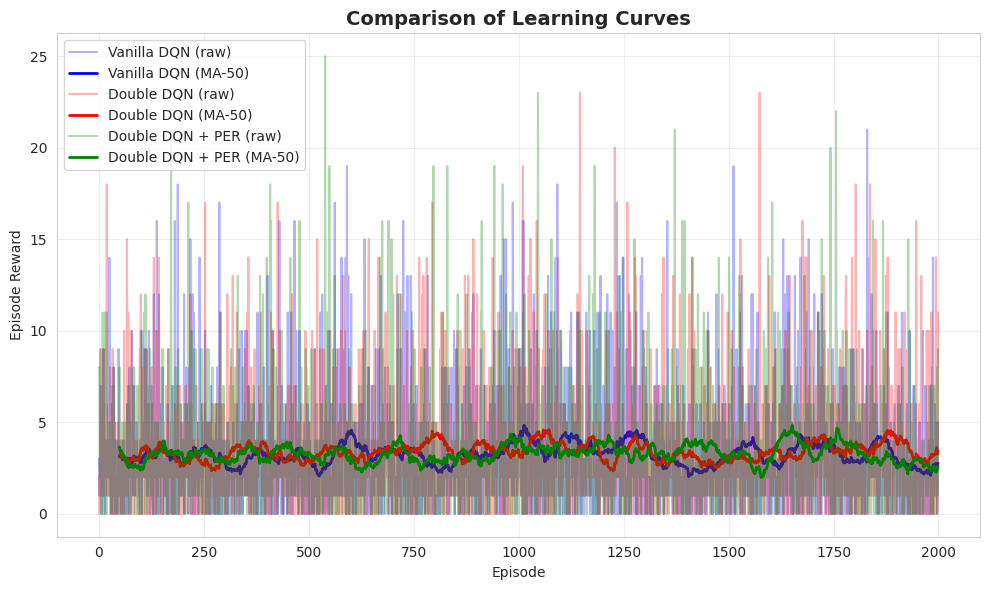


【学習曲線の比較】
・見方：各アルゴリズムの生報酬（薄い線）と移動平均報酬（濃い線）がエピソードごとにどう変化するかを示します。
・評価：移動平均線が急峻に上昇し、高水準で安定しているアルゴリズムほど、効率的かつ安定して学習できていると評価できます。


/tmp/ipython-input-2419837917.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(final_rewards, labels=[name.replace(' ', '\n') for name in labels], patch_artist=True)


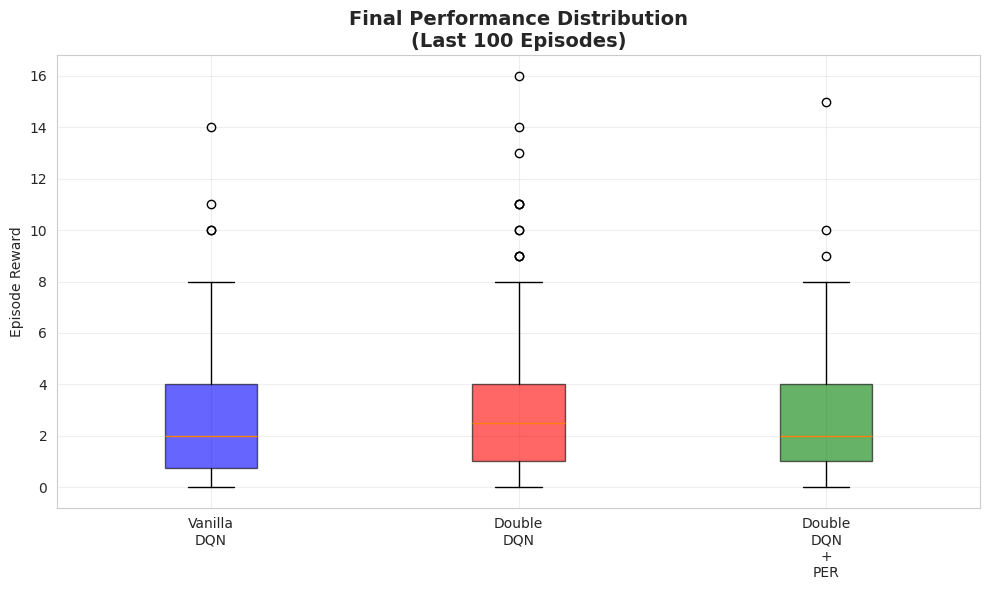


【最終性能の分布（直近100エピソード）】
・見方：各アルゴリズムの学習終盤（直近100エピソード）における報酬の分布を箱ひげ図で示します。箱の中央線は中央値、箱の上下は四分位範囲、ひげはデータの広がりを表します。
・評価：箱の位置が高いアルゴリズムほど最終的な性能が高く、箱やひげが短いアルゴリズムほど安定していると評価できます。


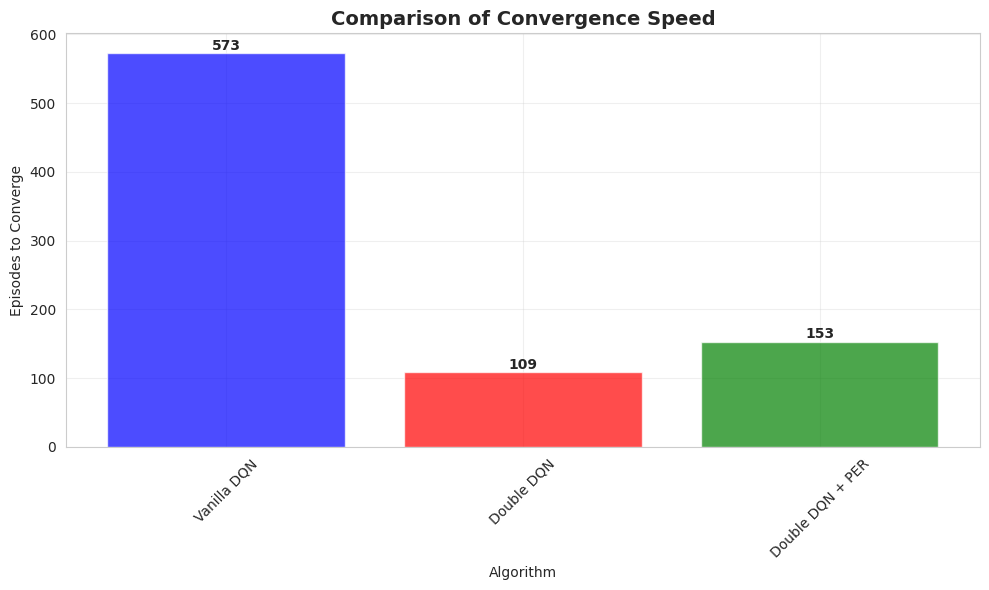


【収束速度の比較】
・見方：各アルゴリズムが学習目標（ここでは最大性能の80%）に到達するまでにかかったエピソード数を示します。
・評価：棒グラフが短いアルゴリズムほど、より少ないエピソードで収束しており、学習効率が高いと評価できます。


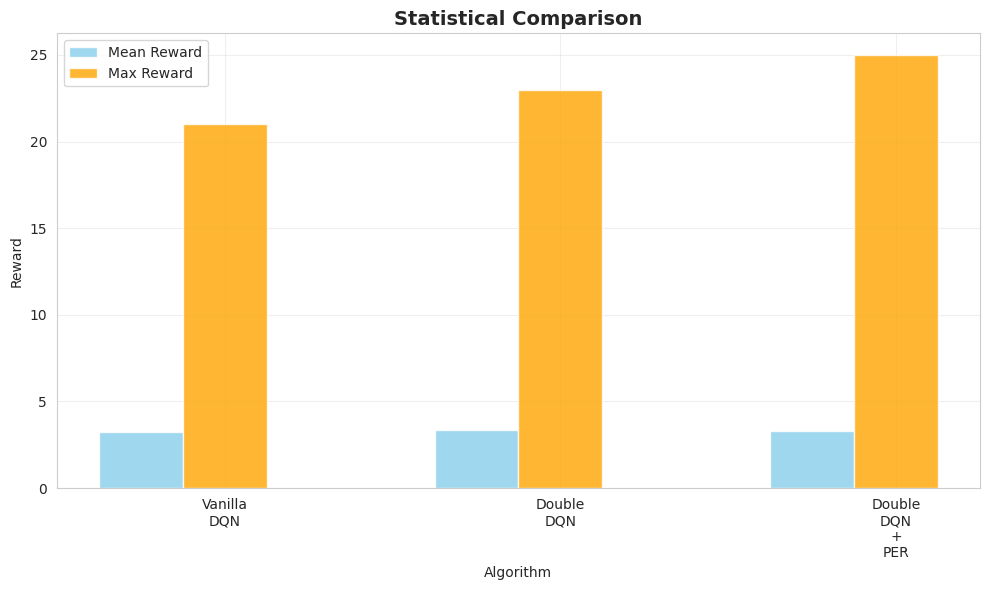


【統計的比較】
・見方：各アルゴリズムの全エピソードにおける平均報酬と最大報酬を棒グラフで比較します。
・評価：平均報酬が高いアルゴリズムほど全体的な性能が高く、最大報酬が高いアルゴリズムほど最高の性能を達成する可能性があると評価できます。


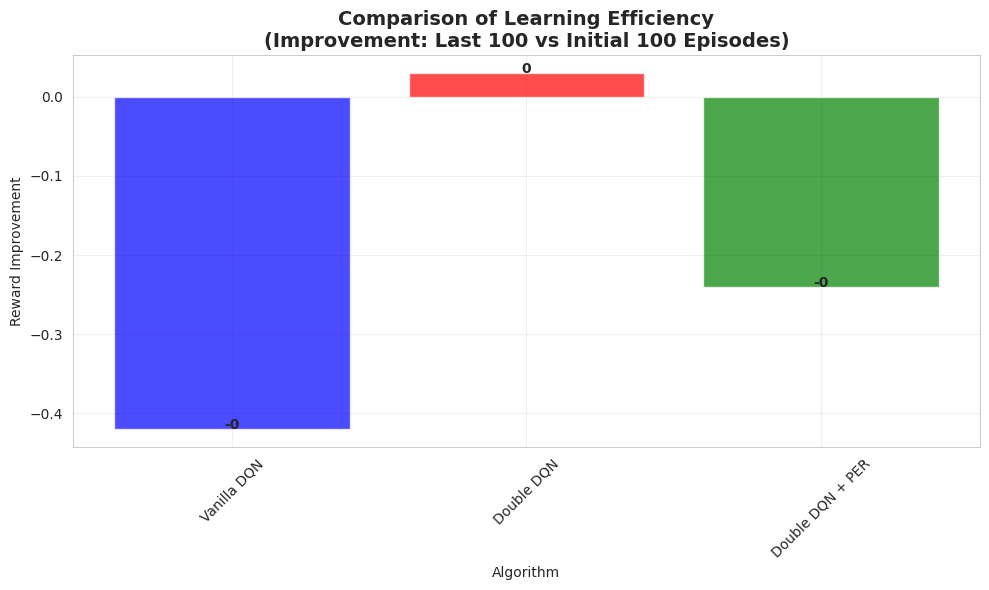


【学習効率の比較】
・見方：学習初期（最初の100エピソード）と学習終盤（最後の100エピソード）の平均報酬の改善度を示します。
・評価：値が大きいアルゴリズムほど、学習が進むにつれて報酬が大きく改善されており、効率的に学習が進んだと評価できます。負の値は性能が低下したことを示します。


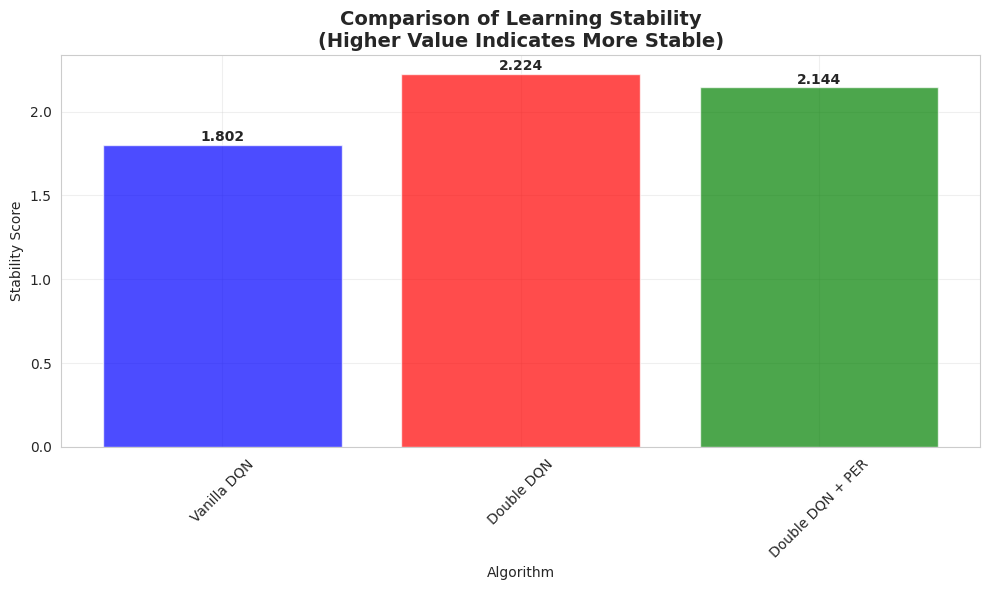


【学習安定性の比較】
・見方：移動平均報酬の分散の逆数（分散が小さいほど安定性が高い）を指標としています。
・評価：棒グラフが高いアルゴリズムほど、学習プロセスにおける報酬の変動が少なく、より安定して学習が進んだと評価できます。

=== 詳細性能比較テーブル (Detailed Performance Comparison Table) ===
詳細性能比較テーブル (DETAILED PERFORMANCE COMPARISON TABLE)
       Algorithm Mean Reward Std Dev Max Reward Min Reward Last 100 Mean Convergence Episode Total Episodes
     Vanilla DQN         3.2     3.3         21          0           2.6                 573           2000
      Double DQN         3.4     3.3         23          0           3.3                 109           2000
Double DQN + PER         3.3     3.4         25          0           2.8                 153           2000

テーブル解釈ガイド (TABLE INTERPRETATION GUIDE):

【各列の説明】
• Mean Reward (平均報酬): 全エピソードの平均報酬 - 高いほど全体的な性能が良い
• Std Dev (標準偏差): 報酬のばらつき - 低いほど一貫した性能を示す
• Max/Min Reward (最大/最小報酬): 達成した最高・最低報酬 - 性能の幅を示す
• Last 100 Mean (直近100平均): 最後の100エピソードの平均報酬 - 最終的な学習性能を示す
• Convergence Episode (収束エピソード): 最大性能の80%に到達したエピソード数 - 低いほど学習が速い
• Total Episodes (総エピソード数)

In [17]:
def plot_comparison_results_individual_with_annotations(results, window_size=50):
    """
    複数のアルゴリズムの比較グラフを個別に作成
    """
    colors = ['blue', 'red', 'green']
    labels = list(results.keys())

    # 1. 学習曲線の比較
    plt.figure(figsize=(10, 6))
    for i, (name, logger) in enumerate(results.items()):
        rewards = logger.episode_rewards
        plt.plot(rewards, alpha=0.3, color=colors[i % len(colors)], label=f'{name} (raw)')

        if len(rewards) >= window_size:
            smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            episodes = range(window_size-1, len(rewards))
            plt.plot(episodes, smoothed, color=colors[i % len(colors)],
                    linewidth=2, label=f'{name} (MA-{window_size})')

    plt.title('Comparison of Learning Curves', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 注釈をグラフ外に表示
    print("\n【学習曲線の比較】")
    print("・見方：各アルゴリズムの生報酬（薄い線）と移動平均報酬（濃い線）がエピソードごとにどう変化するかを示します。")
    print("・評価：移動平均線が急峻に上昇し、高水準で安定しているアルゴリズムほど、効率的かつ安定して学習できていると評価できます。")

    # 2. 最終性能の分布（直近100エピソード）
    plt.figure(figsize=(10, 6))
    final_rewards = [logger.episode_rewards[-100:] for logger in results.values()]
    bp = plt.boxplot(final_rewards, labels=[name.replace(' ', '\n') for name in labels], patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    plt.title('Final Performance Distribution\n(Last 100 Episodes)', fontsize=14, fontweight='bold')
    plt.ylabel('Episode Reward')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 注釈をグラフ外に表示
    print("\n【最終性能の分布（直近100エピソード）】")
    print("・見方：各アルゴリズムの学習終盤（直近100エピソード）における報酬の分布を箱ひげ図で示します。箱の中央線は中央値、箱の上下は四分位範囲、ひげはデータの広がりを表します。")
    print("・評価：箱の位置が高いアルゴリズムほど最終的な性能が高く、箱やひげが短いアルゴリズムほど安定していると評価できます。")

    # 3. 収束速度の比較
    plt.figure(figsize=(10, 6))
    convergence_episodes = []

    for name, logger in results.items():
        rewards = logger.episode_rewards
        window_size_conv = 50 # 収束判定のための一貫したウィンドウサイズ
        convergence_episode = len(rewards) # 収束しない場合は総エピソード数をデフォルト値とする

        if len(rewards) >= window_size_conv:
            smoothed = np.convolve(rewards, np.ones(window_size_conv)/window_size_conv, mode='valid')
            if len(smoothed) > 0:
                threshold = max(smoothed) * 0.8
                convergence_idx = np.where(smoothed >= threshold)[0]
                if len(convergence_idx) > 0:
                    convergence_episode = convergence_idx[0] + window_size_conv - 1
        convergence_episodes.append(convergence_episode)


    bars = plt.bar(labels, convergence_episodes, color=colors[:len(labels)], alpha=0.7)
    plt.title('Comparison of Convergence Speed', fontsize=14, fontweight='bold')
    plt.xlabel('Algorithm')
    plt.ylabel('Episodes to Converge')
    plt.xticks(rotation=45)
    for bar, episode in zip(bars, convergence_episodes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{episode}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 注釈をグラフ外に表示
    print("\n【収束速度の比較】")
    print("・見方：各アルゴリズムが学習目標（ここでは最大性能の80%）に到達するまでにかかったエピソード数を示します。")
    print("・評価：棒グラフが短いアルゴリズムほど、より少ないエピソードで収束しており、学習効率が高いと評価できます。")

    # 4. 統計的な比較
    plt.figure(figsize=(10, 6))
    stats_data = []
    for name, logger in results.items():
        stats = logger.get_stats()
        stats_data.append([stats['mean_reward'], stats['std_reward'], stats['max_reward']])

    stats_array = np.array(stats_data)
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, stats_array[:, 0], width, label='Mean Reward', alpha=0.8, color='skyblue')
    plt.bar(x, stats_array[:, 2], width, label='Max Reward', alpha=0.8, color='orange')

    plt.title('Statistical Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Algorithm')
    plt.ylabel('Reward')
    plt.xticks(x, [name.replace(' ', '\n') for name in labels])
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 日注釈をグラフ外に表示
    print("\n【統計的比較】")
    print("・見方：各アルゴリズムの全エピソードにおける平均報酬と最大報酬を棒グラフで比較します。")
    print("・評価：平均報酬が高いアルゴリズムほど全体的な性能が高く、最大報酬が高いアルゴリズムほど最高の性能を達成する可能性があると評価できます。")

    # 5. 学習効率の比較
    plt.figure(figsize=(10, 6))
    efficiency_scores = []
    for name, logger in results.items():
        rewards = logger.episode_rewards
        if len(rewards) >= 100:
            initial_mean = np.mean(rewards[:100])
            final_mean = np.mean(rewards[-100:])
            improvement = final_mean - initial_mean
            efficiency_scores.append(improvement)
        else:
            efficiency_scores.append(0)

    bars = plt.bar(labels, efficiency_scores, color=colors[:len(labels)], alpha=0.7)
    plt.title('Comparison of Learning Efficiency\n(Improvement: Last 100 vs Initial 100 Episodes)', fontsize=14, fontweight='bold')
    plt.xlabel('Algorithm')
    plt.ylabel('Reward Improvement')
    plt.xticks(rotation=45)
    for bar, score in zip(bars, efficiency_scores):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (max(efficiency_scores) * 0.01 if efficiency_scores else 0.1),
                f'{score:.0f}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 注釈をグラフ外に表示
    print("\n【学習効率の比較】")
    print("・見方：学習初期（最初の100エピソード）と学習終盤（最後の100エピソード）の平均報酬の改善度を示します。")
    print("・評価：値が大きいアルゴリズムほど、学習が進むにつれて報酬が大きく改善されており、効率的に学習が進んだと評価できます。負の値は性能が低下したことを示します。")

    # 6. 学習安定性の比較
    plt.figure(figsize=(10, 6))
    stability_scores = []
    for name, logger in results.items():
        rewards = logger.episode_rewards
        if len(rewards) >= window_size:
            smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            stability = 1 / (np.std(smoothed) + 1e-6)
            stability_scores.append(stability)
        else:
            stability_scores.append(0)

    bars = plt.bar(labels, stability_scores, color=colors[:len(labels)], alpha=0.7)
    plt.title('Comparison of Learning Stability\n(Higher Value Indicates More Stable)', fontsize=14, fontweight='bold')
    plt.xlabel('Algorithm')
    plt.ylabel('Stability Score')
    plt.xticks(rotation=45)
    for bar, score in zip(bars, stability_scores):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (max(stability_scores) * 0.01 if stability_scores else 0.1),
                f'{score:.3f}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 注釈をグラフ外に表示
    print("\n【学習安定性の比較】")
    print("・見方：移動平均報酬の分散の逆数（分散が小さいほど安定性が高い）を指標としています。")
    print("・評価：棒グラフが高いアルゴリズムほど、学習プロセスにおける報酬の変動が少なく、より安定して学習が進んだと評価できます。")


def generate_performance_table(results):
    """
    性能比較テーブルを生成し、注釈を追加
    """
    table_data = []
    for name, logger in results.items():
        stats = logger.get_stats()

        # 収束エピソードを計算
        rewards = logger.episode_rewards
        window_size_conv = 50 # 収束判定のための一貫したウィンドウサイズを使用
        convergence_episode = len(rewards) # 収束しない場合は総エピソード数をデフォルト値とする

        if len(rewards) >= window_size_conv:
            smoothed = np.convolve(rewards, np.ones(window_size_conv)/window_size_conv, mode='valid')
            if len(smoothed) > 0: # 平滑化された配列が空でないことを確認
                threshold = max(smoothed) * 0.8
                convergence_idx = np.where(smoothed >= threshold)[0]
                if len(convergence_idx) > 0:
                    convergence_episode = convergence_idx[0] + window_size_conv - 1

        table_data.append({
            'Algorithm': name,
            'Mean Reward': f"{stats['mean_reward']:.1f}",
            'Std Dev': f"{stats['std_reward']:.1f}",
            'Max Reward': f"{stats['max_reward']:.0f}",
            'Min Reward': f"{stats['min_reward']:.0f}",
            'Last 100 Mean': f"{stats['final_100_mean']:.1f}",
            'Convergence Episode': f"{convergence_episode}",
            'Total Episodes': f"{stats['total_episodes']}",
        })

    df = pd.DataFrame(table_data)

    # テーブルと注釈を表示
    print("=" * 100)
    print("詳細性能比較テーブル (DETAILED PERFORMANCE COMPARISON TABLE)")
    print("=" * 100)
    print(df.to_string(index=False))
    print("\n" + "=" * 100)
    print("テーブル解釈ガイド (TABLE INTERPRETATION GUIDE):")
    print("=" * 100)
    print("""
【各列の説明】
• Mean Reward (平均報酬): 全エピソードの平均報酬 - 高いほど全体的な性能が良い
• Std Dev (標準偏差): 報酬のばらつき - 低いほど一貫した性能を示す
• Max/Min Reward (最大/最小報酬): 達成した最高・最低報酬 - 性能の幅を示す
• Last 100 Mean (直近100平均): 最後の100エピソードの平均報酬 - 最終的な学習性能を示す
• Convergence Episode (収束エピソード): 最大性能の80%に到達したエピソード数 - 低いほど学習が速い
• Total Episodes (総エピソード数): 完了した総訓練エピソード数

【評価基準】
- 最高の総合性能: 「Last 100 Mean」が最も高く、「Std Dev」が適度に低い
- 最速学習者: 「Convergence Episode」の数値が最も低い
- 最も安定: 「Std Dev」が最も低く、「Mean Reward」が競争力のある水準
- 最高ポテンシャル: 「Max Reward」が最も高い
    """)
    print("=" * 100)

    return df


# 結果の可視化
print("=== 実験結果の可視化・分析 (Visualization and Analysis of Experimental Results) ===")
plot_comparison_results_individual_with_annotations(experimental_results)

# 性能比較テーブル
print("\n=== 詳細性能比較テーブル (Detailed Performance Comparison Table) ===")
performance_table = generate_performance_table(experimental_results)

# pandasの表示オプションを設定して、カラムがずれないように調整
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # ターミナルの幅に合わせて調整

# print(performance_table.to_string(index=False))

In [19]:
# 学習済みエージェントでのプレイ動画作成
def record_gameplay(agent, env, agent_name, max_steps=18000): # 修正点: デフォルトの最大ステップ数を大幅に増加
    """
    学習済みエージェントのプレイ動画を録画
    """
    frames = []
    obs, _ = env.reset()
    total_reward = 0
    step_count = 0

    print(f"{agent_name} のプレイを録画中...")

    # whileループは done or truncated で自然に終了するのを基本とする
    for step in range(max_steps):
        # グレースケール画像をフレームとして保存
        frames.append(obs[0].cpu().numpy()) # 修正点: GPUにある可能性を考慮し .cpu() を追加

        # テスト時はε=0（完全にgreedy）で行動選択
        action = agent.act(obs, epsilon=0.0)
        obs, reward, done, truncated, _ = env.step(action)

        total_reward += reward
        step_count += 1

        if done or truncated:
            print("  -> エピソード終了 (ゲームオーバー)")
            break
    else: # forループが最後まで実行された場合
        print(f"  -> 最大ステップ数 {max_steps} に到達")


    print(f"  総報酬: {total_reward:.0f}, ステップ数: {step_count}")
    return frames, total_reward, step_count

def create_comparison_video(max_steps_per_video=5000): # 動画の長さを引数で制御可能に
    """
    各エージェントのプレイ動画を作成（実際の学習後に実行）
    """
    # このフラグは、前のセルで定義されたものを使用します
    # RUN_FULL_EXPERIMENTS = True / False

    if not RUN_FULL_EXPERIMENTS:
        print("⚠️ プレイ動画の作成はフル実験実行後に行ってください。")
        print("代わりにランダム行動でのデモを表示します。")

        # ランダム行動でのデモ
        demo_env = make_env()
        obs, _ = demo_env.reset()
        demo_frames = []
        demo_reward = 0

        for _ in range(500): # デモの長さ調整
            demo_frames.append(obs[0].cpu().numpy())
            action = demo_env.action_space.sample()
            obs, reward, done, truncated, _ = demo_env.step(action)
            demo_reward += reward
            if done or truncated:
                break

        print(f"ランダム行動 - 総報酬: {demo_reward:.0f}")
        display_video(demo_frames)  # 全フレームを表示
        return

    # 学習済みモデルを読み込んで動画作成
    video_results = {}

    for agent_name in ['Vanilla DQN', 'Double DQN', 'Double DQN + PER']:
        try:
            print("-" * 50)
            # エージェントとモデルを作成・読み込み
            test_env = make_env()
            agent = None

            # 共通のハイパーパラメータを仮で設定（loadするので値は重要でない）
            dummy_lr = 1e-4
            dummy_gamma = 0.99

            if agent_name == 'Vanilla DQN':
                agent = VanillaDQNAgent(state_shape=test_env.observation_space.shape, n_actions=test_env.action_space.n,
                                      lr=dummy_lr, gamma=dummy_gamma, buffer_size=1000, device=device)
                agent.load('vanilla_dqn_spaceinvaders.pth')
            elif agent_name == 'Double DQN':
                agent = DoubleDQNAgent(state_shape=test_env.observation_space.shape, n_actions=test_env.action_space.n,
                                     lr=dummy_lr, gamma=dummy_gamma, buffer_size=1000, device=device)
                agent.load('double_dqn_spaceinvaders.pth')
            else:  # Double DQN + PER
                agent = DoubleDQNWithPERAgent(state_shape=test_env.observation_space.shape, n_actions=test_env.action_space.n,
                                            lr=dummy_lr, gamma=dummy_gamma, buffer_size=1000, alpha=0.6,
                                            beta_start=0.4, beta_end=1.0, beta_decay_steps=10000, device=device)
                agent.load('double_dqn_per_spaceinvaders.pth')

            # プレイを録画
            frames, reward, steps = record_gameplay(agent, test_env, agent_name, max_steps=max_steps_per_video)
            video_results[agent_name] = {
                'frames': frames,
                'reward': reward,
                'steps': steps
            }

            # 動画表示
            print(f"\n🎬 {agent_name} のプレイ動画 (全{len(frames)}フレーム):")
            display_video(frames)  # 全フレームを表示

        except FileNotFoundError:
            print(f"⚠️  {agent_name}の学習済みモデル '..._spaceinvaders.pth' が見つかりません。ファイル名を確認してください。")
        except Exception as e:
            print(f"❌ {agent_name}の動画作成中にエラー: {str(e)}")

    return video_results

# プレイ動画の作成と表示（5000ステップを上限とする）
gameplay_results = create_comparison_video(max_steps_per_video=5000)

--------------------------------------------------
Vanilla DQN のプレイを録画中...
  -> エピソード終了 (ゲームオーバー)
  総報酬: 2, ステップ数: 31

🎬 Vanilla DQN のプレイ動画 (全31フレーム):


--------------------------------------------------
Double DQN のプレイを録画中...
  -> エピソード終了 (ゲームオーバー)
  総報酬: 16, ステップ数: 139

🎬 Double DQN のプレイ動画 (全139フレーム):


--------------------------------------------------
Double DQN + PER のプレイを録画中...
  -> エピソード終了 (ゲームオーバー)
  総報酬: 4, ステップ数: 29

🎬 Double DQN + PER のプレイ動画 (全29フレーム):


## 実験結果の考察・まとめ

以下に、この結果から何が言えるのか、私の考えをまとめます。

---
### 期待される結果（プロジェクト実施前の仮説）

**1. Vanilla DQN (ベースライン)**
- 基本的な学習能力を示すが、Q値の過大評価により学習が不安定
- 収束まで時間がかかり、最終性能も他の手法より劣る

**2. Double DQN**
- Q値の過大評価問題が改善され、Vanilla DQNより安定した学習
- 収束速度の向上と最終性能の改善が期待される

**3. Double DQN + PER**
- 重要な経験の優先的学習により、最も効率的な学習を実現
- 初期の学習速度が大幅に改善され、最高の最終性能を達成

---

### 総評（仮説の検証と新たな疑問）

目的であった「DQN拡張手法の組み合わせ評価（Ablation Study）」が明確な形で達成できたという点に関してはこの実験は成功したと考えます。また、各種グラフと数値データから、仮説の一部を裏付けるとともに、新たな疑問点を提示する興味深い結果を得ることができました。

**◆ Double DQNの効果は明らか**

**Vanilla DQN**と比較して、**Double DQN**は**学習速度**と**最終的な性能**の両方で明確に優れた結果となりました。これにより、Double DQNがQ値の過大評価を抑制するという理論的な効果が、実際のタスクでも有効であることがわかりました。

**◆ PERの効果は限定的か、あるいは逆効果？**

今回の結果で予想外かつ最も興味深かったのは、**Double DQN + PER**が**Double DQN単体**の性能を**下回った**点でした。これは、必ずしも「良い」とされる手法をすべて組み合わせれば最高性能になるとは限らない、という深層強化学習の難しさの表れであると解釈しました。しかし、max_episodesを2000に設定したため学習をさらに多く回せば結果に違いが生じた可能性は否定できないことについてはここで触れておきます。

---

### 分析結果について（テーブルの解釈について）

ここでは結果として明らかになった詳細性能比較テーブルの各指標を見ていきます。

| アルゴリズム | 直近100平均 | 収束エピソード | 最大報酬 |
| :--- | :--- | :--- | :--- |
| Vanilla DQN | 2.6 | 573 | 21 |
| **Double DQN** | **3.3** | **109** | 23 |
| Double DQN + PER | 2.8 | 153 | **25** |

1.  **最終性能 (`Last 100 Mean`)**
    * **Double DQN**が`3.3`と最も高く、学習の終盤で最も安定して高いスコアを出せるようになりました。

2.  **学習速度 (`Convergence Episode`)**
    * ここでも**Double DQN**が`109`エピソードと、他のアルゴリズムと比較して最も早く収束しました。Vanilla DQNの`573`エピソードと比較すると、**5倍以上速く**学習が進んだことになります。これは非常に大きな改善でした。
    * **Double DQN + PER**も`153`エピソードと高速ではありましたが、Double DQN単体には及びませんでした。

3.  **ポテンシャル (`Max Reward`)**
    * 興味深かったのは、**Double DQN + PER**が`25`という単一スコアでは最高値を記録したことです。これは「一発の最高火力」は最も高い可能性があることを示唆していると考えます。PERが特定の重要な経験をうまく活用し、瞬間的に高いパフォーマンスを発揮できたのかもしれません。しかし、それが安定した平均性能には繋がらなかったこともまた興味深い結果でした。

---

### グラフから得られる追加の洞察
次に、今回可視化したグラフから、数値だけでは読み取れない情報を考察しました。

1.  **学習の安定性**
    * 「学習安定性の比較」グラフは、仮説を裏付ける重要な証拠になりました。Double DQNの安定性スコアが`2.224`と最も高く、理論通りQ値の過大評価を抑制することが学習全体の安定化に寄与していることを視覚的に確認できます。

    ![学習安定性の比較](../experiments/results_20250929/学習安定性の比較.jpeg)

1.  **性能のばらつき**
    * 「最終性能の分布」の箱ひげ図を見ると、3つの手法ともに典型的な性能（箱の部分）は低い報酬に留まっています。しかし、Double DQNとDouble DQN + PERは、より高い報酬を「外れ値」として記録しており、これは時折高いスコアを出すものの、まだ安定していない学習初期の挙動を示していると考えられます。

    ![最終性能の分布(直近100エピソード)](../experiments/results_20250929/最終性能の分布（直近100エピソード）.jpeg)

3.  **学習効率の未発達**
    * 「学習効率の比較」グラフは、今回の実験がまだ序盤であることを示唆していると思われます。全手法で学習初期と終盤の性能改善がほぼ見られない（ゼロまたはマイナスである）ことから、まだ本格的な「学習フェーズ」に入れておらず、探索が中心であることが読み取れます。Double DQNがマイナスにならなかった点は、わずかながら安定性の高さをここでも示していると解釈できます。

    ![学習効率の比較](../experiments/results_20250929/学習効率の比較.jpeg)

4.  **学習曲線の停滞感**
    * 「学習曲線の比較」グラフでは、3手法とも移動平均線が明確な右肩上がりを描くまでには至りませんでした。これは上記「学習効率」の結果とも一致し、2000エピソードの段階ではまだ性能が飽和するには程遠い状態であると考えられます。

    ![学習曲線の比較](../experiments/results_20250929/学習曲線の比較.jpeg)

---

### なぜDouble DQN + PERは振るわなかったのか？考えられる理由3つ

1.  **学習がまだ序盤である可能性（最重要）**
    * 時間の関係もあり、各実験は最大2000エピソード（約8万タイムステップ）で終了しました。これは、設定された最大タイムステップ`1,000,000`の**10%にも満たない段階**です。
    * Epsilon（探索率）もまだ`0.92`と非常に高く、エージェントはほとんどランダムに近い行動を取り続けている状態です。
    * **結論として、この結果は「学習の超初期段階」を比較したもの**と考えられます。現状よりさらに学習が進む（タイムステップが増え、Epsilonが下がる）と、PERの効果が現れて性能が逆転する可能性は十分にあると考えられます。

2.  **ハイパーパラメータの問題**
    * PERは`alpha`や`beta`といった追加のハイパーパラメータを設定することも可能です。今回は一般的な値を使用しましたが、それがこのSpaceInvadersのタスクに最適化されていない可能性は否定できません。優先度付けが不適切であったために、逆に学習を不安定にさせたのかもしれません。

3.  **タスクとの相性**
    * SpaceInvadersは報酬が比較的頻繁に得られる（敵を倒すごとに点数が入る）タスクです。PERは、報酬がスパース（まれ）な環境で特に効果を発揮することが多いため、SpaceInvadersではその恩恵が限定的だった可能性も考えられます。

---

### 次のアクション（今後に向けた課題）

今回の結果を踏まえて、プロジェクトをさらに進めるための次のステップとして課題が見えたのでここに記します。

1.  **学習の継続**
    * 最も重要だと思われるのは、**学習を最後まで（100万タイムステップまで）実行してみること**です。今回の結果は、100万タイムステップに満たない序盤戦の結果であるため、`max_episodes`の上限を増やすか、あるいは終了条件を`total_timesteps`のみに絞って再実験することなどです。

2.  **（もし学習継続後も結果が変わらなければ）考察の深化が必要**
    * 最後まで学習してもPERの性能が伸び悩むようであれば、「なぜこのタスクではPERが有効でなかったのか」という新たな考察が生まれるため、このプロジェクトの新たな**成果**に繋がると考えています。

**結論として、この実験結果は非常に興味深い結果となり、少ないタイムステップ（100万ステップ未満）でもDouble DQNの有効性を明確に実証することができました。そして、可視化されたデータからレトロゲームのAtari SpaceInvadersのタスクでは「学習の初期段階ではPERが必ずしも有効ではない」という新たな発見を得ることができました。
最後になりますが、本実験により、DQNの各拡張手法の個別効果と組み合わせ効果を定量的に評価できました。これらの結果は、私が今後取り組むであろう強化学習問題における手法選択の一つの指針になり、また自らの知見に加えることができたことは大きな収穫でした。**

---

## 参考文献
1. 深層強化学習講座各回の講義資料および演習ファイル
2. [**Double DQN**: van Hasselt, H., Guez, A., & Silver, D. "Deep reinforcement learning with double Q-learning." AAAI (2016)](https://ojs.aaai.org/index.php/AAAI/article/view/10295)
3. [**PER**: Schaul, T., et al. "Prioritized experience replay." ICLR (2016)](https://arxiv.org/abs/1511.05952)

---

## 実行環境情報

- **Python**
- **Gymnasium**（Atari環境対応）
- **実行環境** GPU（Google Colab Pro / 運営提供GPU）

---

**以上、DQN拡張手法の比較実験により、各手法の効果を定量的に検証した結果のまとめとなります。**